In [1]:
# !pip install plotly

In [2]:
import plotly.express as px

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm



from random import choices
from scipy import stats
from tqdm.notebook import tqdm

In [4]:
from jupyter_utils import mean_std, display_test, display_group_test, scatter_annotate, show_corrtest_mask_corr
from ortogonolize_utils import draw_scatter, draw_corrected_scatter
from ortogonolize_utils import compute_coefficient, compute_ortogonolized_coefficient, compute_ortogonolized_logit

In [5]:
import warnings
warnings.filterwarnings(action="ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

In [6]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/'

# Patients

In [7]:
df = pd.read_excel(PATH +'NAP/GR_all6M_MPP.xlsx', index_col=0, na_values=[' ', '', -99.0])
df = df[df.index.notnull()].drop(columns=['Unnamed: 98', 'Unnamed: 99'])

In [8]:
# total positve ftd - saps34; total alogia - sans12
# sex_nr - female = 1, male = 0
# ausja_bl = education years at baseline (i.e. 6 months before the NET interview)
# pa - panss

# df.columns

In [9]:
# print(*enumerate('PANSS P1	PANSS P2	PANSS P3	PANSS P4	PANSS P5	PANSS P6	PANSS P7	PANSS N1	PANSS N2	PANSS N3	PANSS N4	PANSS N5	PANSS N6	PANSS N7	PANSS O1	PANSS O2	PANSS O3	PANSS O4	PANSS O5	PANSS O6	PANSS O7	PANSS O8	PANSS 09	PANSS O10	PANSS O11	PANSS O12	PANSS O13	PANSS O14	PANSS O15	PANSS 016'.split('\t')))

In [10]:
df['panss_pos'] = df[['pa_01', 'pa_02', 'pa_03', 'pa_04', 'pa_05', 'pa_06', 'pa_07']].sum(axis=1)
df['panss_neg'] = df[['pa_08', 'pa_09', 'pa_10', 'pa_11', 'pa_12', 'pa_13', 'pa_14', 'pa_15']].sum(axis=1)
df['panss_o'] = df[['pa_16', 'pa_17', 'pa_18', 'pa_19', 'pa_20', 'pa_21', 'pa_22', 'pa_23', 'pa_24', 'pa_25', 'pa_26', 'pa_27', 'pa_28', 'pa_29', 'pa_30']].sum(axis=1)
df['panss_total'] = df[['panss_pos', 'panss_neg', 'panss_o']].sum(axis=1)
df['saps_total'] = df[['saps1', 'saps2', 'saps3', 'saps4', 'saps5', 'saps6', 'saps7', 'saps8', 'saps9', 'saps10', 'saps11', 'saps12', 'saps13', 'saps14', 'saps15', 'saps16', 'saps17', 'saps18', 'saps19', 'saps20', 'saps21', 'saps22', 'saps23', 'saps24', 'saps25', 'saps26', 'saps27', 'saps28', 'saps29', 'saps30', 'saps31', 'saps32', 'saps33', 'saps34', 'saps35']].sum(axis=1)
df['sans_total'] =  df[['sans1', 'sans2', 'sans3', 'sans4', 'sans5', 'sans6', 'sans7', 'sans8', 'sans9', 'sans10', 'sans11', 'sans12', 'sans13', 'sans14', 'sans15', 'sans16', 'sans17', 'sans18', 'sans19', 'sans20', 'sans21', 'sans22', 'sans23', 'sans24']].sum(axis=1)

#### Filter out only the patients there are transcripts for

In [11]:
# df.index

In [12]:
df.index.rename('ID', inplace=True)

In [13]:
res = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_patients.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [14]:
res.dropna(how='all', inplace=True)

In [15]:
idxs = sorted([x.replace('_6M_manual_c', '') for x in res.index])
idxs = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in idxs]

In [16]:
res.index = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in [x.replace('_6M_manual_c', '') for x in res.index]]
res.index.rename('ID', inplace=True)

In [17]:
assert not set(idxs).difference(set(df.index))

In [18]:
df = df.loc[idxs]

#### Look at descriptitve stats

In [19]:
cols = ['age', 'sex_nr', 'Bildungsjahre', 'IQ_kristallin', 'saps34', 'saps_total', 'sans_total', 'sans12', 'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [20]:
df[cols].count()

age              59
sex_nr           59
Bildungsjahre    59
IQ_kristallin    58
saps34           59
saps_total       59
sans_total       59
sans12           59
panss_pos        59
panss_neg        59
panss_o          59
panss_total      59
dtype: int64

In [21]:
mean_std(df, cols)

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,39.49 (11.11),0.41 (0.5),14.62 (2.95),105.16 (15.65),1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)


In [22]:
mean_std(df, cols, 'sex_nr')

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
sex_nr,,,,,,,,,,,,
0.0,37.29 (10.12),0.0 (0.0),14.54 (3.11),107.0 (12.7),1.03 (1.04),18.57 (16.7),28.63 (21.23),0.94 (1.24),13.37 (5.61),17.14 (6.6),28.64 (7.63),59.15 (16.99)
1.0,42.71 (11.9),1.0 (0.0),14.73 (2.78),102.35 (19.28),1.04 (1.08),14.25 (16.71),26.42 (19.37),0.88 (1.15),11.62 (5.22),16.42 (5.17),26.45 (7.3),54.5 (14.84)


In [23]:
df.groupby('sex_nr').count()['age']

sex_nr
0.0    35
1.0    24
Name: age, dtype: int64

In [24]:
# df.age.hist();

# Healthy controls

In [25]:
df_hc = pd.read_csv(PATH + 'HC/NET_HC.csv', index_col=0, na_values=[' ', ''])

In [26]:
df_hc.columns

Index(['age', 'sex_nr', 'Bildungsjahre'], dtype='object')

#### Look up descriptive stats

In [27]:
df_hc.count()

age              20
sex_nr           20
Bildungsjahre    19
dtype: int64

In [28]:
mean_std(df_hc, ['age', 'Bildungsjahre'])

,age,Bildungsjahre
value,43.85 (13.29),15.5 (2.78)


In [29]:
mean_std(df_hc, ['age', 'Bildungsjahre'], 'sex_nr')

,age,Bildungsjahre
sex_nr,,
0.0,42.27 (12.24),15.7 (3.13)
1.0,45.78 (14.99),15.28 (2.51)


In [30]:
df_hc.groupby('sex_nr').count()

,age,Bildungsjahre
sex_nr,,
0.0,11,10
1.0,9,9


In [31]:
# df_hc.index

#### Check that all the transcripts are availble

In [32]:
res_hc =  pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_HC.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [33]:
idxs_HC = sorted([x.replace('_c', '').replace('NET_', '')  for x in res_hc.index])

In [34]:
assert not set(idxs_HC).difference(set(df_hc.index))

In [35]:
df_hc = df_hc.loc[idxs_HC]

In [36]:
df_hc.index.rename('ID', inplace=True)

In [37]:
res_hc.index = [x.replace('_c', '').replace('NET_', '')  for x in res_hc.index]
res_hc.index.rename('ID', inplace=True)

In [38]:
merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')
corr_hc = merged_hc.corr()

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_16690/1853110338.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')


#### Fill NA in syntactic (percentage of unused POS should be zero, not NA)

In [39]:
cols_LM = [col for col in merged_hc if col[0] == 'LM']
cols_synt = [col for col in merged_hc if col[0] == 'syntactic']
cols_lex = [col for col in merged_hc if col[0] == 'lexical']
cols_graph = [col for col in merged_hc if col[0] == 'graph']

In [40]:
pos = set([x[1] for x in cols_synt if x[1].isupper()])

In [41]:
pos.difference(set(('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')))

{'ADP', 'INTJ', 'NUM', 'PUNCT', 'SPACE', 'X'}

In [42]:
POS_to_use = ('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')

In [43]:
s = merged_hc[cols_synt].isna().any()
s[s].index

Index([('syntactic', 'INTJ'), ('syntactic', 'NUM'), ('syntactic', 'X')], dtype='object')

In [44]:
merged_hc[s[s].index] = merged_hc[s[s].index].fillna(0.0)

In [45]:
merged_hc.drop(columns=[c for c in cols_synt if c[1].isupper() and c[1] not in POS_to_use], inplace=True)

In [46]:
cols_to_drop = [(task, *c) for c in cols_synt if c[1].isupper() and c[1] not in POS_to_use for task in res.columns.unique(level='TASK')]
res.drop(columns=cols_to_drop, inplace=True)

In [47]:
cols_synt = [col for col in merged_hc if col[0] == 'syntactic']
cols_av = cols_synt + cols_LM + cols_lex + cols_graph

In [48]:
# merged_hc[s[s].index][merged_hc[cols_synt].isna().any(axis=1)]

### Analyze the effects of age in healthy controls

In [49]:
# df_hc.age.hist();

In [50]:
df_hc[df_hc.age > 60]

,age,sex_nr,Bildungsjahre
ID,,,
KG_010,65.0,0.0,18.0
KG_015,68.0,1.0,16.0


In [51]:
corr_hc[abs(corr_hc['age']) > 0.3]['age']

age                          1.000000
(graph, PE)                  0.320571
(graph, degree_average)      0.306332
(graph, degree_std)          0.307724
(syntactic, NUM)            -0.303372
(syntactic, PRON)            0.312938
(syntactic, VERB)            0.323338
(syntactic, X)               0.305444
(syntactic, min_sent_len)    0.374543
Name: age, dtype: float64

In [52]:
corr_hc[abs(corr_hc['age']) > 0.3].index

Index([                        'age',               ('graph', 'PE'),
         ('graph', 'degree_average'),       ('graph', 'degree_std'),
                ('syntactic', 'NUM'),         ('syntactic', 'PRON'),
               ('syntactic', 'VERB'),            ('syntactic', 'X'),
       ('syntactic', 'min_sent_len')],
      dtype='object')

In [53]:
# merged_hc.plot.scatter('age', ('syntactic', 'PRON'));

In [54]:
# merged_hc.plot.scatter('age', ('syntactic', 'AUX'));

In [55]:
# merged_hc.plot.scatter('age', ('graph', 'degree_std'));

In [56]:
# merged_hc.plot.scatter('age', ('syntactic', 'VERB'));

In [57]:
corr_hc[abs(corr_hc['age']) > 0.5].index

Index(['age'], dtype='object')

### Analyze the effects of education years in healthy controls

In [58]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.3].index

Index([               'Bildungsjahre',               ('LM', 'm_gcoh'),
                     ('LM', 'm_lcoh'),          ('LM', 'm_raw_cgcoh'),
                 ('LM', 'm_raw_gcoh'),           ('LM', 'm_raw_lcoh'),
                 ('LM', 'm_raw_scoh'),               ('LM', 'm_scoh'),
                      ('graph', 'L1'),                ('graph', 'L3'),
               ('lexical', 'n_words'),         ('syntactic', 'CCONJ'),
                 ('syntactic', 'NUM'),         ('syntactic', 'PUNCT'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len')],
      dtype='object')

In [59]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.5].index

Index(['Bildungsjahre'], dtype='object')

In [60]:
# merged_hc.plot.scatter('Bildungsjahre', ('LM', 'm_scoh'));

In [61]:
stats.pearsonr(corr_hc['Bildungsjahre'], corr_hc[('syntactic', 'std_sent_len')])

PearsonRResult(statistic=0.6366715016054222, pvalue=5.109462641544746e-07)

In [62]:
# merged_hc.plot.scatter('Bildungsjahre', ('syntactic', 'std_sent_len'));

### Analyze the effects of sentence length in healthy controls

In [63]:
# merged_hc[('syntactic', 'mean_sent_len')].plot.hist();

In [64]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.3].index

Index([               'Bildungsjahre',              ('LM', 'm_cgcoh'),
                     ('LM', 'm_gcoh'),               ('LM', 'm_lcoh'),
                ('LM', 'm_raw_cgcoh'),           ('LM', 'm_raw_gcoh'),
                 ('LM', 'm_raw_lcoh'),           ('LM', 'm_raw_scoh'),
                     ('LM', 'm_scoh'),              ('LM', 'm_sporb'),
                      ('graph', 'L2'),               ('graph', 'LCC'),
                     ('graph', 'LSC'),        ('graph', 'degree_std'),
         ('graph', 'number_of_nodes'),             ('lexical', 'LTR'),
                 ('lexical', 'MALTR'),         ('lexical', 'n_words'),
                 ('syntactic', 'ADV'),           ('syntactic', 'DET'),
                ('syntactic', 'INTJ'),          ('syntactic', 'PART'),
               ('syntactic', 'PROPN'),         ('syntactic', 'PUNCT'),
                   ('syntactic', 'X'),  ('syntactic', 'max_sent_len'),
       ('syntactic', 'mean_sent_len'),  ('syntactic', 'std_sent_len')],
     

In [65]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.5].index

Index([             ('LM', 'm_cgcoh'),               ('LM', 'm_gcoh'),
                     ('LM', 'm_lcoh'),          ('LM', 'm_raw_cgcoh'),
                 ('LM', 'm_raw_gcoh'),           ('LM', 'm_raw_lcoh'),
                 ('LM', 'm_raw_scoh'),               ('LM', 'm_scoh'),
                    ('LM', 'm_sporb'),                ('graph', 'L2'),
               ('lexical', 'n_words'),           ('syntactic', 'DET'),
                ('syntactic', 'INTJ'),         ('syntactic', 'PROPN'),
               ('syntactic', 'PUNCT'),  ('syntactic', 'max_sent_len'),
       ('syntactic', 'mean_sent_len'),  ('syntactic', 'std_sent_len')],
      dtype='object')

In [66]:
corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index

Index([             ('LM', 'm_cgcoh'),               ('LM', 'm_gcoh'),
                     ('LM', 'm_lcoh'),          ('LM', 'm_raw_cgcoh'),
                 ('LM', 'm_raw_gcoh'),           ('LM', 'm_raw_lcoh'),
                 ('LM', 'm_raw_scoh'),               ('LM', 'm_scoh'),
                    ('LM', 'm_sporb'),         ('lexical', 'n_words'),
               ('syntactic', 'PROPN'),         ('syntactic', 'PUNCT'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len')],
      dtype='object')

In [67]:
corr_hc.loc[corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index][('syntactic', 'mean_sent_len')].sort_values(key=lambda x: abs(x), ascending=False)

(syntactic, mean_sent_len)    1.000000
(syntactic, std_sent_len)     0.963781
(syntactic, max_sent_len)     0.908025
(LM, m_raw_gcoh)              0.906231
(LM, m_raw_lcoh)              0.898075
(LM, m_raw_cgcoh)             0.890917
(syntactic, PUNCT)           -0.876596
(LM, m_raw_scoh)              0.874910
(LM, m_lcoh)                  0.858456
(LM, m_scoh)                  0.838873
(LM, m_gcoh)                  0.822198
(LM, m_sporb)                 0.740797
(LM, m_cgcoh)                 0.691730
(syntactic, PROPN)           -0.637486
(lexical, n_words)            0.631810
Name: (syntactic, mean_sent_len), dtype: float64

In [68]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'));

In [69]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_scoh'));

In [70]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'));

In [71]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_gcoh'));

In [72]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_lcoh'));

# Merge control and patient data

In [73]:
df['group'] = 1
df_hc['group'] = 0
compare_groups = pd.concat([df[cols + ['group']], df_hc], axis=0)

In [74]:
compare_groups.groupby(['group']).count()

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
group,,,,,,,,,,,,
0,20,20,19,0,0,0,0,0,0,0,0,0
1,59,59,59,58,59,59,59,59,59,59,59,59


In [75]:
mean_std(compare_groups, ['age', 'Bildungsjahre'], 'group')

,age,Bildungsjahre
group,,
0,43.85 (13.29),15.5 (2.78)
1,39.49 (11.11),14.62 (2.95)


In [76]:
# sns.histplot(compare_groups['saps_total']);

In [77]:
# sns.histplot(compare_groups['sans_total']);

In [78]:
stats.ttest_ind(df['age'], df_hc['age']).pvalue

0.15339927043476997

In [79]:
stats.ttest_ind(df['Bildungsjahre'], df_hc['Bildungsjahre'], nan_policy='omit').pvalue

0.2552563345667248

In [80]:
combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_16690/1114475667.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')


### Fill NA in syntactic  (percentage of unused POS should be zero, not NA)

In [81]:
s = combined_data_averaged[cols_synt].isna().any()
s[s].index

Index([('syntactic', 'ADJ'), ('syntactic', 'PROPN')], dtype='object')

In [82]:
# combined_data_averaged[s[s].index][combined_data_averaged[cols_synt].isna().any(axis=1)]

In [83]:
combined_data_averaged[s[s].index] = combined_data_averaged[s[s].index].fillna(0.0)

In [84]:
# combined_data_averaged.columns

# Analyze the differences in control factors

In [85]:
clinical_cols = ['age',
 'Bildungsjahre',
 'IQ_kristallin',
 'saps34',
 'saps_total',
 'sans_total',
 'sans12',
 'panss_pos',
 'panss_neg',
 'panss_o',
 'panss_total']

In [86]:
# cols_av = [('LM', 'm_lcoh'), ('LM', 'm_gcoh'), ('LM', 'm_cgcoh'), ('LM', 'm_scoh'), ('LM', 'm_sporb'), ('LM', 'm_bert_lcoh'), ('LM', 'm_bert_gcoh'), ('LM', 'm_bert_cgcoh'), ('LM', 'm_bert_scoh'),
#            ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len'), ('syntactic', 'std_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'max_sent_len'), ('syntactic', 'SPACE'), ('syntactic', 'NOUN'), ('syntactic', 'X'), ('syntactic', 'PUNCT'), ('syntactic', 'VERB'), ('syntactic', 'ADV'), ('syntactic', 'ADP'), ('syntactic', 'ADJ'), ('syntactic', 'CCONJ'), ('syntactic', 'PRON'),
#            ('syntactic', 'DET'), ('syntactic', 'AUX'), ('syntactic', 'PROPN'), ('syntactic', 'PART'), ('syntactic', 'SCONJ'), ('syntactic', 'INTJ'), ('syntactic', 'NUM'),
#            ('lexical', 'n_words'), ('lexical', 'LTR'), ('lexical', 'MALTR'),
#            ('graph', 'number_of_nodes'), ('graph', 'number_of_edges'), ('graph', 'PE'), ('graph', 'LCC'), ('graph', 'LSC'), ('graph', 'degree_average'), ('graph', 'degree_std'), ('graph', 'L1'), ('graph', 'L2'), ('graph', 'L3')
#           ]

### Group difference for sex (absent)

In [87]:
a = 0.001
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, clinical_cols, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
res_t_sex['sig'].any()

False

In [88]:
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, cols_av, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
res_t_sex['sig'].any()

False

### Correlative difference for age, education years, and IQ (absent)

In [89]:
x, y = display_test(combined_data_averaged, cols_av, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.2].sort_values('abs_r', ascending=False)['sig'].any()

False

In [90]:
x, y = display_test(combined_data_averaged, cols_av, 'Bildungsjahre', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)['sig'].any()

False

In [91]:
x, y = display_test(combined_data_averaged, cols_av, 'IQ_kristallin', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
"(syntactic, AUX)",0.335383,0.010064,False,0.335383


In [92]:
# normalized_combined_data_averaged = combined_data_averaged.copy()
# normalized_combined_data_averaged[cols_av] = (combined_data_averaged[cols_av]-combined_data_averaged[cols_av].min())/(combined_data_averaged[cols_av].max()-combined_data_averaged[cols_av].min())

In [93]:
combined_data_averaged.to_csv('averaged.csv')

# Analyze the metric performance

## Group difference & correlation with PANSS, SANS, and SAPS

In [94]:
a = 0.001
s_t, res_t = display_group_test(combined_data_averaged, cols_av, 'group', stats.ttest_ind, stat_name='t', alpha=a)

In [95]:
def corr_test_cols(data, cols_av, traget_cols, corrtest=stats.pearsonr, stat_name='r', alpha=a):
    df = pd.DataFrame()
    for target_col in traget_cols:
        r = display_test(data, cols_av, target_col, stats.pearsonr, stat_name=target_col, alpha=a)[1][target_col]
        df = pd.concat([df, r], axis=1)
    return df

In [96]:
scales = ["saps_total", "sans_total", "panss", "panss_pos", "panss_neg", "panss_o"]
s_saps, r_saps = display_test(combined_data_averaged, cols_av, 'saps_total', stats.pearsonr, stat_name='r', alpha=a)
s_sans, r_sans = display_test(combined_data_averaged, cols_av, 'sans_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss, r_panss = display_test(combined_data_averaged, cols_av, 'panss_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss_pos, r_panss_pos = display_test(combined_data_averaged, cols_av, 'panss_pos', stats.pearsonr, stat_name='r', alpha=a)
s_panss_neg, r_panss_neg = display_test(combined_data_averaged, cols_av, 'panss_neg', stats.pearsonr, stat_name='r', alpha=a)
s_panss_o, r_panss_o = display_test(combined_data_averaged, cols_av, 'panss_o', stats.pearsonr, stat_name='r', alpha=a)
combined_corr = pd.concat([res_t, r_saps, r_sans, r_panss, r_panss_pos, r_panss_neg, r_panss_o], 
                     keys= ['t_test'] + scales, 
                     names=["scale"], axis=1)

In [97]:
combined_corr[('mean', 'abs_r')] = combined_corr[[(scale, 'abs_r') for scale in scales]].mean(axis=1)
mean_abs_r = combined_corr.pop(('mean', 'abs_r'))
combined_corr.insert(0, ('mean', 'abs_r'), mean_abs_r) 

In [98]:
# combined_corr[[(scale, 'abs_r') for scale in ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]]].mean(axis=1)
t_p_n_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in ['sans_total', 'saps_total']], axis=1).mean(axis=1)
mean_rank = pd.concat([combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in scales], axis=1).mean(axis=1)
combined_corr.insert(1, ('mean', 'rank'), mean_rank) 
combined_corr.insert(2, ('mean', 'rank_abs'), mean_rank.rank()) 
combined_corr.insert(1, ('mean', 'tpn_rank'), t_p_n_rank) 
combined_corr.insert(2, ('mean', 'tpn_rank_abs'), t_p_n_rank.rank()) 

In [99]:
# combined_corr.sort_values(('mean', 'rank'))[['mean', 't_test']].apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

## Analyze the relation between t-test and correlation with psychiatric scales

In [100]:
stats.pearsonr(combined_corr[('mean', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.3290874806565517, pvalue=0.03333375905109242)

In [101]:
stats.pearsonr(combined_corr[('panss', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.2989426821141045, pvalue=0.05446289943176182)

In [102]:
stats.pearsonr(combined_corr[('saps_total', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=-0.14924162078561806, pvalue=0.3455249972127127)

In [103]:
stats.pearsonr(combined_corr[('panss_pos', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=-0.275950907332415, pvalue=0.07690691856123506)

In [104]:
stats.pearsonr(combined_corr[('sans_total', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.5251020015864638, pvalue=0.0003564261774084722)

In [105]:
# sns.scatterplot(x=combined_corr[('sans_total', 'abs_r')], y=combined_corr[('t_test', 'abs_t')]);

In [106]:
stats.pearsonr(combined_corr[('panss_neg', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.5130005887154403, pvalue=0.0005129334404604816)

In [107]:
# sns.scatterplot(x=combined_corr[('panss_neg', 'abs_r')], y=combined_corr[('t_test', 'abs_t')]);

### Analyze interaction with length

In [108]:
corr_len_s, corr_len = display_test(combined_data_averaged, cols_av, ('syntactic', 'mean_sent_len'), stats.pearsonr, stat_name='r', alpha=a)

In [109]:
y = corr_len['abs_r']
tt_norm = (combined_corr['t_test', 'abs_t'] - combined_corr['t_test', 'abs_t'].min()) / (combined_corr['t_test', 'abs_t'].max() - combined_corr['t_test', 'abs_t'].min())

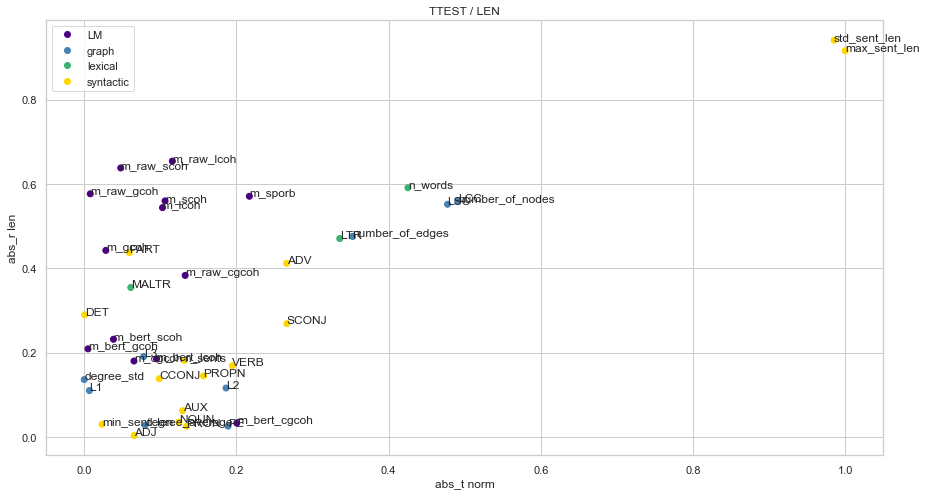

In [202]:
y = corr_len['abs_r']
z = tt_norm

n = [x[-1] for x in tt_norm.index]
c_map = {'LM': 0, 'graph': 1, 'lexical': 2, 'syntactic': 3}
c = [c_map[label[0]] for label in tt_norm.index]

plt.rcParams["figure.figsize"] = (15,8)
scatter_annotate(z, y, n, 'abs_t norm', 'abs_r len', 'TTEST / LEN', c=c)

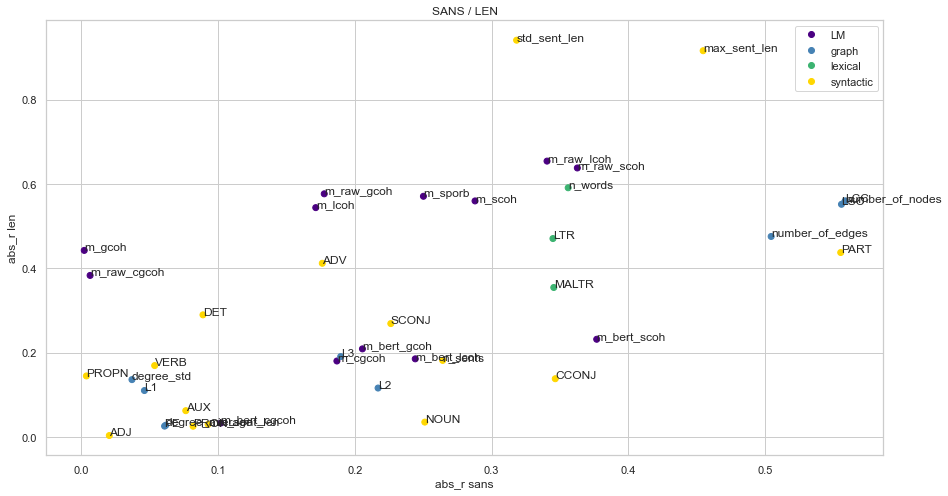

In [203]:
y = corr_len['abs_r']
z = combined_corr['sans_total', 'abs_r']

scatter_annotate(z, y, n, 'abs_r sans', 'abs_r len', 'SANS / LEN', c)

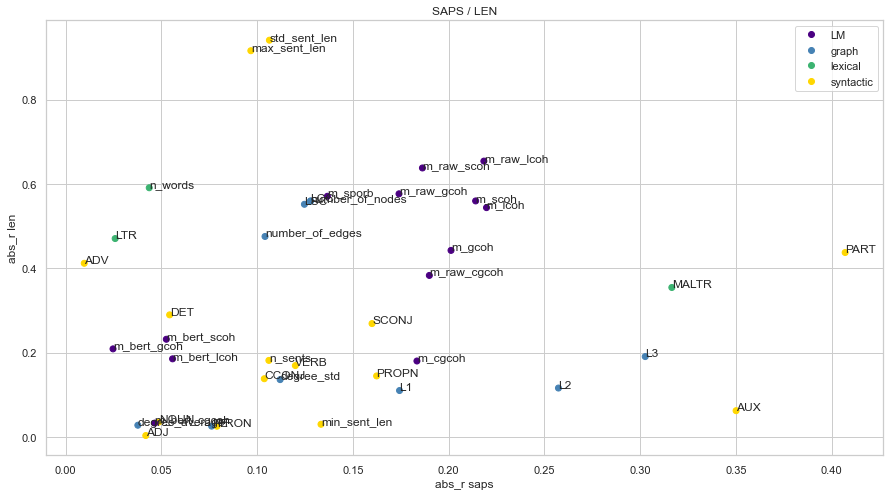

In [204]:
y = corr_len['abs_r']
z = combined_corr['saps_total', 'abs_r']

scatter_annotate(z, y, n, 'abs_r saps', 'abs_r len', 'SAPS / LEN', c)

## Analyze correlation tables

In [113]:
# corr = show_corrtest_mask_corr(combined_data_averaged[cols])
## 1. age does not correlate with IQ, education years, or psychiatric scales
## 2. IQ does not correlate with education years or psychiatric scales
## 3. saps-total correlates with saps34 and panss_pos
## 4. sans-total correlates with sans12 and panss_neg, panss_o, panss_total
## 5. panss-total correlates with panss_o, panss_neg, sans-total, panss_pos, saps-total

In [114]:
num_scale_cols = ['saps34','saps_total', 'sans_total', 'sans12',
                  'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [115]:
r = mean_std(combined_data_averaged, num_scale_cols)
r

,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)


In [116]:
r.loc['max'] = pd.Series([5, 170, 120, 5, 49, 49, 112, 210], index=r.columns)
r.loc['min'] = pd.Series([0, 0, 0, 0, 7, 7, 16, 30], index=r.columns)
r.loc['share'] = r.loc['value'].apply(lambda x: float(x.split(' ')[0])) / r.loc['max'] 

In [117]:
r

,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)
max,5,170,120,5,49,49,112,210
min,0,0,0,0,7,7,16,30
share,0.206,0.098882,0.231083,0.184,0.258367,0.343878,0.247768,0.272667


In [118]:
# corr = show_corrtest_mask_corr(combined_data_averaged[num_scale_cols])

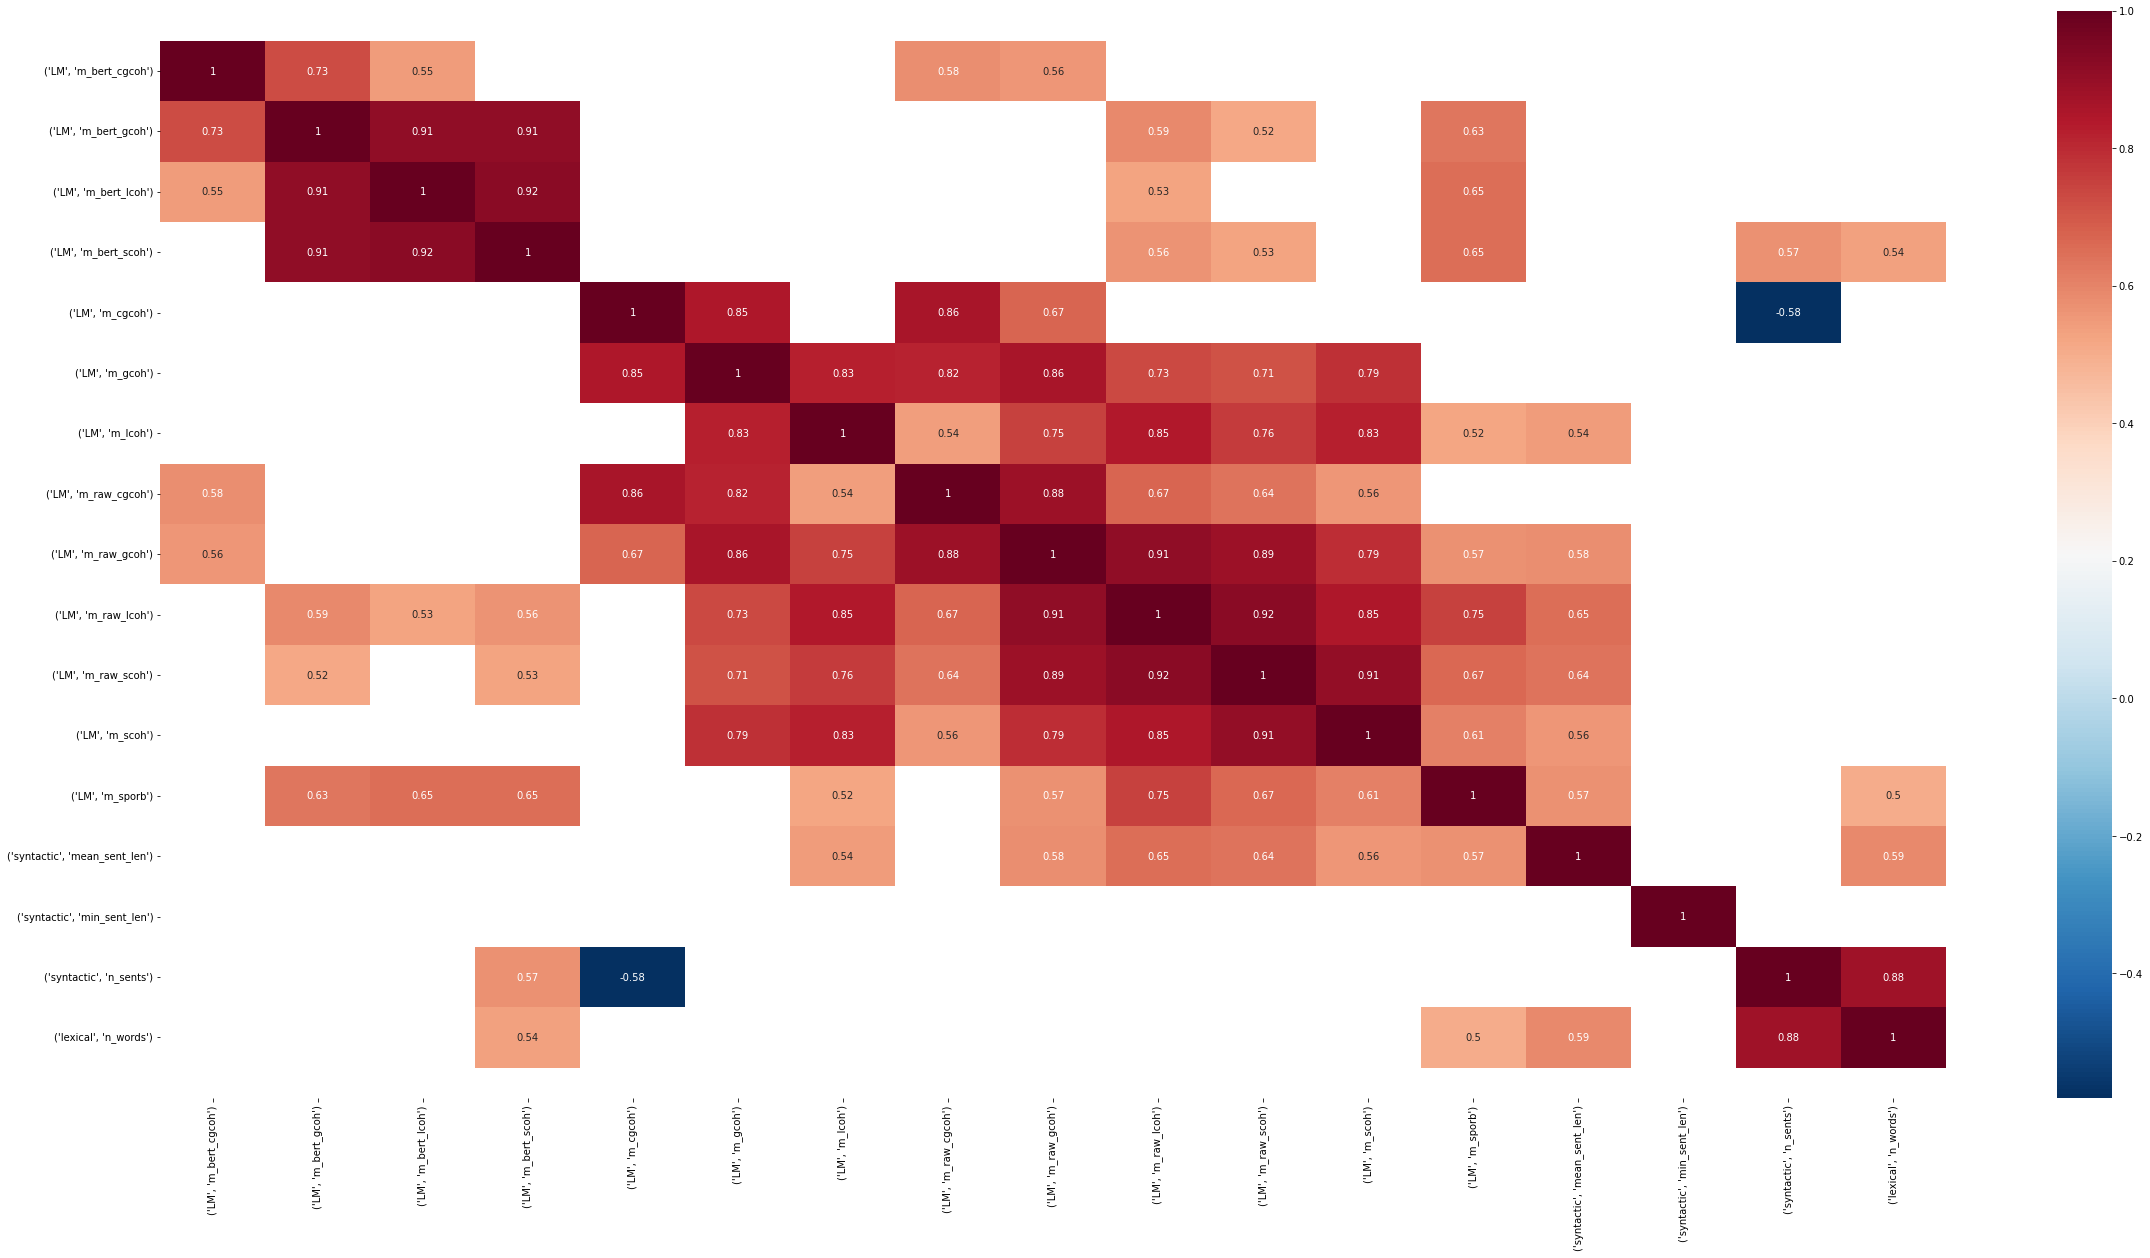

In [119]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_LM + [('syntactic', 'mean_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]]);
## m_lcoh, m_gcoh, m_cgcoh, m_scoh;  m_raw_lcog, m_raw_scoh, m_raw_gcoh, m_raw_cgcoh - all but m_cgcoh
## m_sprob, m_bert_lcoh, m_bert_gcoh, m_bert_cgcoh, m_bert_scoh
## m_raw_cgcoh, m_raw_gcoh + m_bert_cgcoh ; m_raw_lcog, m_raw_scoh + m_bert_gcoh

## m_bert_scoh, m_sprob + n_words
## m_cgcoh - n_sents; m_bert_scoh + n_sents
## m_gcoh, m_lcoh, m_scoh (lcoh strongest);  m_raw - all but cgcoh (ccoh weakest); m_sprob - mean_sent_len

In [120]:
corr[abs(corr[('syntactic', 'mean_sent_len')]) > 0.5][('syntactic', 'mean_sent_len')]

(LM, m_lcoh)                  0.543768
(LM, m_raw_gcoh)              0.576522
(LM, m_raw_lcoh)              0.654084
(LM, m_raw_scoh)              0.637839
(LM, m_scoh)                  0.559634
(LM, m_sporb)                 0.570677
(syntactic, mean_sent_len)    1.000000
(lexical, n_words)            0.590887
Name: (syntactic, mean_sent_len), dtype: float64

In [121]:
corr[abs(corr[('syntactic', 'n_sents')]) > 0.5][('syntactic', 'n_sents')]

(LM, m_bert_scoh)       0.570424
(LM, m_cgcoh)          -0.580744
(syntactic, n_sents)    1.000000
(lexical, n_words)      0.879802
Name: (syntactic, n_sents), dtype: float64

In [122]:
corr[abs(corr[('lexical', 'n_words')]) > 0.5][('lexical', 'n_words')]

(LM, m_bert_scoh)             0.535455
(LM, m_sporb)                 0.503740
(syntactic, mean_sent_len)    0.590887
(syntactic, n_sents)          0.879802
(lexical, n_words)            1.000000
Name: (lexical, n_words), dtype: float64

In [123]:
# corr = show_corrtest_mask_corr(combined_data_averaged[cols_synt])
## noun - det 0.62
## pron - noun -0.5
## sconj - min_sent_len 0.55
## mean - max sent_men 0.92
## max - std sent_len 0.96
## mean - std sent_len 0.94

In [124]:
# corr = show_corrtest_mask_corr(combined_data_averaged[cols_av])

# Control for the effect of length

In [125]:
compute_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'PRON'),
                                  column_names=['pronoun'], target_name='sans', add_sq=False)[0]

0.0067038537605466075

In [126]:
compute_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'),
                                  column_names=['sent len'], target_name='sans', add_sq=False)[0]

0.19662682046537683

In [127]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), 
                                  ('syntactic', 'PRON'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.0011661184394754498

In [128]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), 
                                  ('syntactic', 'min_sent_len'),
                                  column_names=['sent len', 'min sent len'], target_name='sans', add_sq=False)[0]

0.0069434380573168974

### bootstrap 

In [129]:
## 1 sample with replacement

## 1.1 compute_ortogonolized_r for each scale


In [130]:
scale_cols = ['saps_total',
             'sans_total',
             'panss_pos',
             'panss_neg',
             'panss_o',
             'panss_total']

In [131]:
def draw_sample_with_replacement(df, seed=None):
    if seed:
        random.seed(seed)
    length = len(df.index)
    idxs = choices(range(length), k=length)
    return df.iloc[idxs, :]

In [132]:
def t_test(df, column, target_column, test=stats.ttest_ind, nan_policy='omit', stat_name='x', alpha=0.05,
           group_names=None):
    if group_names is None:
        group_names = df[target_column].dropna().unique().tolist()
        assert len(group_names) == 2, 'only two group tests are supported'

    r, p = test(df[df[target_column] == group_names[1]][column],
                df[df[target_column] == group_names[0]][column], nan_policy=nan_policy)
    return r

In [133]:
t_test(combined_data_averaged, ('syntactic', 'mean_sent_len'), 'group', test=stats.ttest_ind, nan_policy='omit', stat_name='x', alpha=0.05)

5.988683527180032

In [134]:
scales = ["saps_total", "sans_total", "panss_total", "panss_pos", "panss_neg", "panss_o"]

def bootstrap(df, cols_av, scale_cols, N, col_to_correct_for=('syntactic', 'mean_sent_len'), group=None):
    dict_scales_sapmles = {k: {scale: {metric: [] for metric in cols_av} for scale in scale_cols} \
                           for k in ('sample_corr', 'sample_raw', 'r', 't', 'r_corr_w_control')}
    for i in tqdm(range(N)):
        sample = draw_sample_with_replacement(df, seed=i)
        for scale in scale_cols:
            for col in cols_av:
                if group:
                    t_test_res = t_test(sample, col, group)
                    dict_scales_sapmles['t'][scale][col].append(t_test_res)
                    
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
                droped = sample.dropna(subset=[col, scale])
                r = stats.pearsonr(droped[col], droped[scale])[0]
                dict_scales_sapmles['r'][scale][col].append(r)
                
                if col != col_to_correct_for:
                    
                    droped_c = sample.dropna(subset=[col, col_to_correct_for])
                    r_c = stats.pearsonr(droped_c[col], droped_c[col_to_correct_for])[0]
                    dict_scales_sapmles['r_corr_w_control'][scale][col].append(r_c)
                    r_corr = compute_ortogonolized_coefficient(sample, scale, col_to_correct_for, col)[0]
                    dict_scales_sapmles['sample_corr'][scale][col].append(r_corr)

    return dict_scales_sapmles

#### expensive to compute

In [135]:
# dict_scales_sapmles = bootstrap(combined_data_averaged, cols_av, scales, 1000, col_to_correct_for=('syntactic', 'mean_sent_len'), group='group')

In [136]:
# reform = {(scale, measure): dict_scales_sapmles[measure][scale] for scale in scale_cols for measure in dict_scales_sapmles}

In [137]:
# with open('de_scales_samples.pickle', 'wb') as f:
#     pickle.dump(reform, f)

In [138]:
with open('de_scales_samples.pickle', 'rb') as f:
    reform = pickle.load(f)

In [139]:
reformed_d = pd.DataFrame(reform)

In [140]:
def pointplot(data, x, y, hue, ax=None, use_errorbar=False, **kwargs):
    sns.set_theme(style="whitegrid")
    if not use_errorbar:
        g = sns.pointplot(
            data=data, x=x, y=y, hue=hue,
            ax=ax, **kwargs);
    else:
        sns.pointplot(
            data=data, x=x, y=y, hue=hue,
            ax=ax, estimator='median', errorbar=('pi', 50), dodge=True,
            err_kws={'alpha':0.3}, capsize=.0, alpha=0.7, **kwargs);

In [141]:
def pointplot_synt(df, x, ax):
    sns.pointplot(
        data=df, x=x, y="metric",
        errorbar=("pi", 50), estimator='median', capsize=.0,
        linestyle="none", hue="metric", palette='tab20',
        err_kws={'alpha':0.3}, alpha=0.7, ax=ax);

In [142]:
def prep_synt_pointplot_errobar_data(df, col, plot_abs=False):
    r = np.concatenate(df[col].to_numpy())
    if plot_abs:
        r = map(abs, r)
    idx = np.concatenate([[x]*len(df[col][x]) for x in df[col].index])
    d = pd.DataFrame(data=r, columns=[col])
    d['metric'] = idx
    return d

In [143]:
def plot_horizontal_tasks(df, title, measure, m_type='syntactic', plot_abs=False, figsize=(18, 18)):
    fig, axes = plt.subplots(3, 2, figsize=figsize, sharex=True)
    fig.suptitle(title)
    
    ab = 'abs_' if plot_abs else ''
    
    d = prep_synt_pointplot_errobar_data(df['panss_pos'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_synt(d, x=measure, ax=axes[0, 0])
    axes[0, 0].set_title(f'{ab}{measure} panss_pos')
    
    d = prep_synt_pointplot_errobar_data(df['panss_neg'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_synt(d, x=measure, ax=axes[0, 1])
    axes[0, 1].set_title(f'{ab}{measure} panss_neg')
    
    d = prep_synt_pointplot_errobar_data(df['saps_total'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_synt(d, x=measure, ax=axes[1, 0])
    axes[1, 0].set_title(f'{ab}{measure} saps_total')
    
    d = prep_synt_pointplot_errobar_data(df['sans_total'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_synt(d, x=measure, ax=axes[1, 1])
    axes[1, 1].set_title(f'{ab}{measure} sans_total')
    
    d = prep_synt_pointplot_errobar_data(df['panss_o'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_synt(d, x=measure, ax=axes[2, 0])
    axes[2, 0].set_title(f'{ab}{measure} panss_o')
    
    d = prep_synt_pointplot_errobar_data(df['panss_total'].loc[m_type], measure, plot_abs=plot_abs)
    pointplot_synt(d, x=measure, ax=axes[2, 1])
    axes[2, 1].set_title(f'{ab}{measure} panss_total')
    

    if plot_abs:
        for ax in axes.reshape(-1): 
            ax.set_xlabel('abs ' + measure);

In [216]:
def plot_all(df, m_type='syntactic', path='/Users/galina.ryazanskaya/Downloads/thesis?/figures/de', 
             dpi=150, plot_abs=False, figsize=(8, 8)):
    ab = 'abs_' if plot_abs else ''
    plot_horizontal_tasks(df, m_type, 'r', m_type=m_type, plot_abs=plot_abs)
    plt.savefig(f'{path}/{m_type}/{ab}scale_r.png', dpi=dpi)
    
    d_t = prep_synt_pointplot_errobar_data(df['panss_o'].loc[m_type], 't')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('t')
    pointplot_synt(d_t, 't', ax=ax)
    plt.savefig(f'{path}/{m_type}/t.png', dpi=dpi)
    
    d_c = prep_synt_pointplot_errobar_data(df['panss_o'].loc[m_type], 'r_corr_w_control')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('corr len')
    pointplot_synt(d_c, 'r_corr_w_control', ax=ax)
    ax.set_title('r corr with len')
    ax.set_xlabel('r corr with len');
    plt.savefig(f'{path}/{m_type}/corr_len.png', dpi=dpi)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('t and corr len')
    pointplot_synt(d_t, x='t', ax=axes[0])
    axes[0].set_title('t')
    pointplot_synt(d_c, x='r_corr_w_control', ax=axes[1])
    axes[1].set_title('r corr with len')
    axes[1].set_xlabel('r corr with len');
    plt.savefig(f'{path}/{m_type}/t_test_corr_len.png', dpi=dpi)

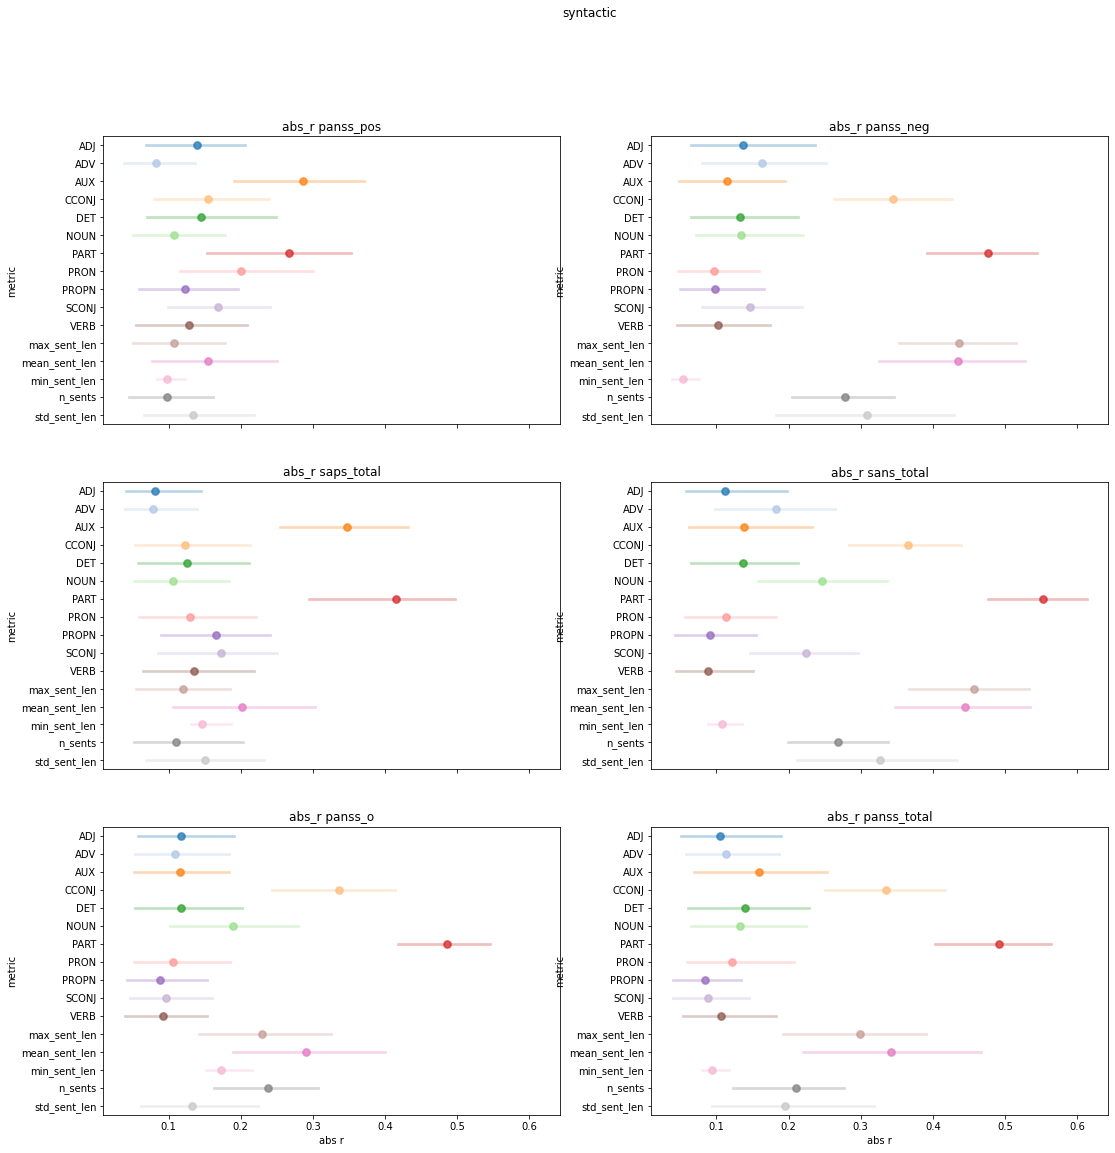

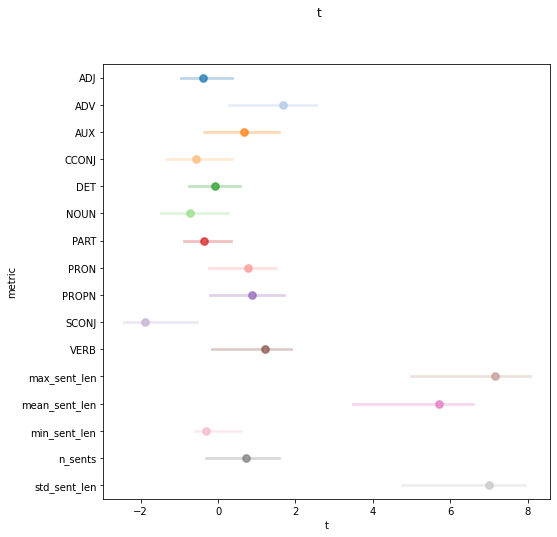

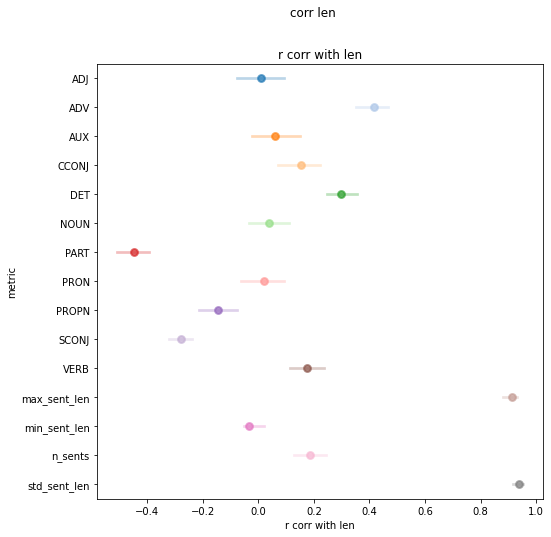

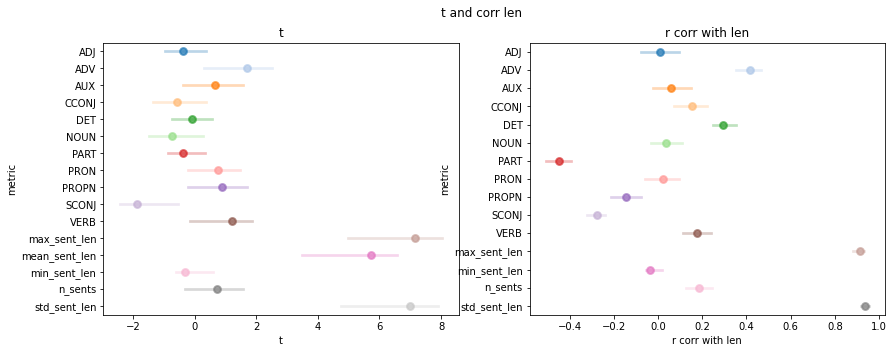

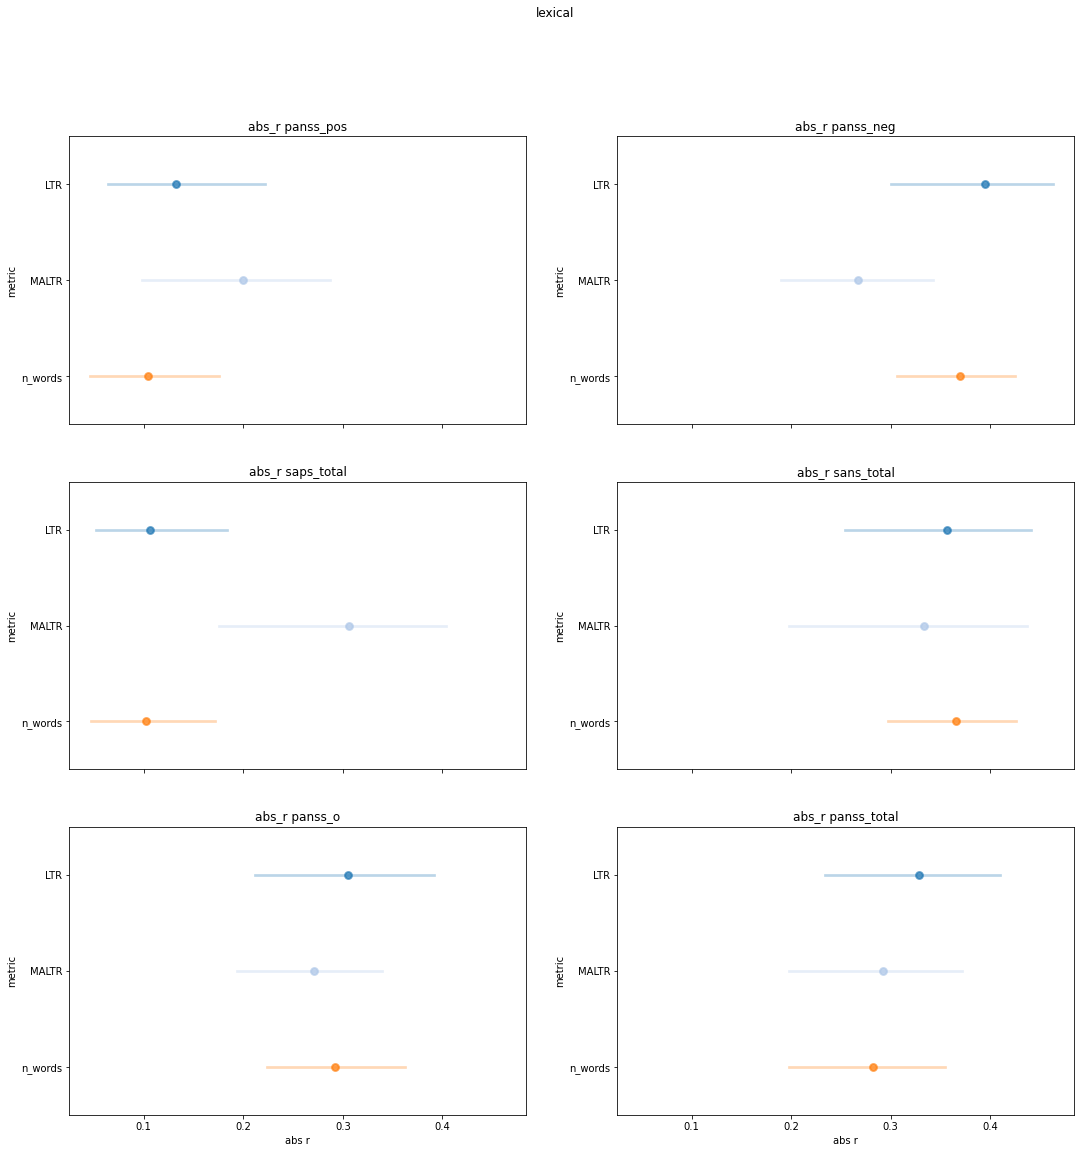

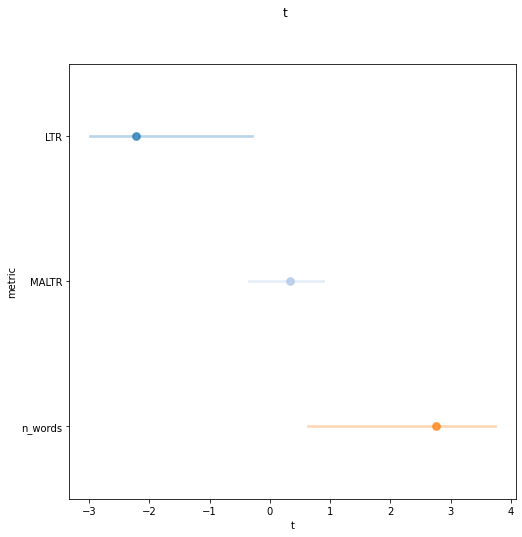

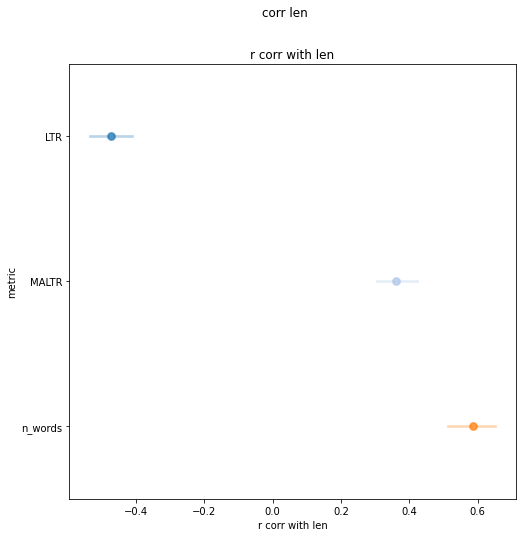

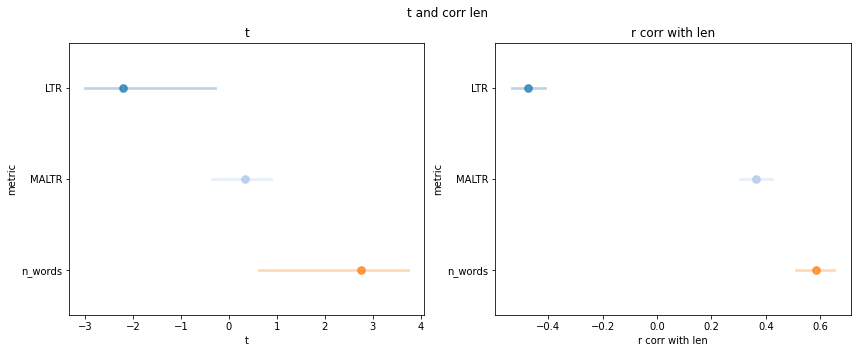

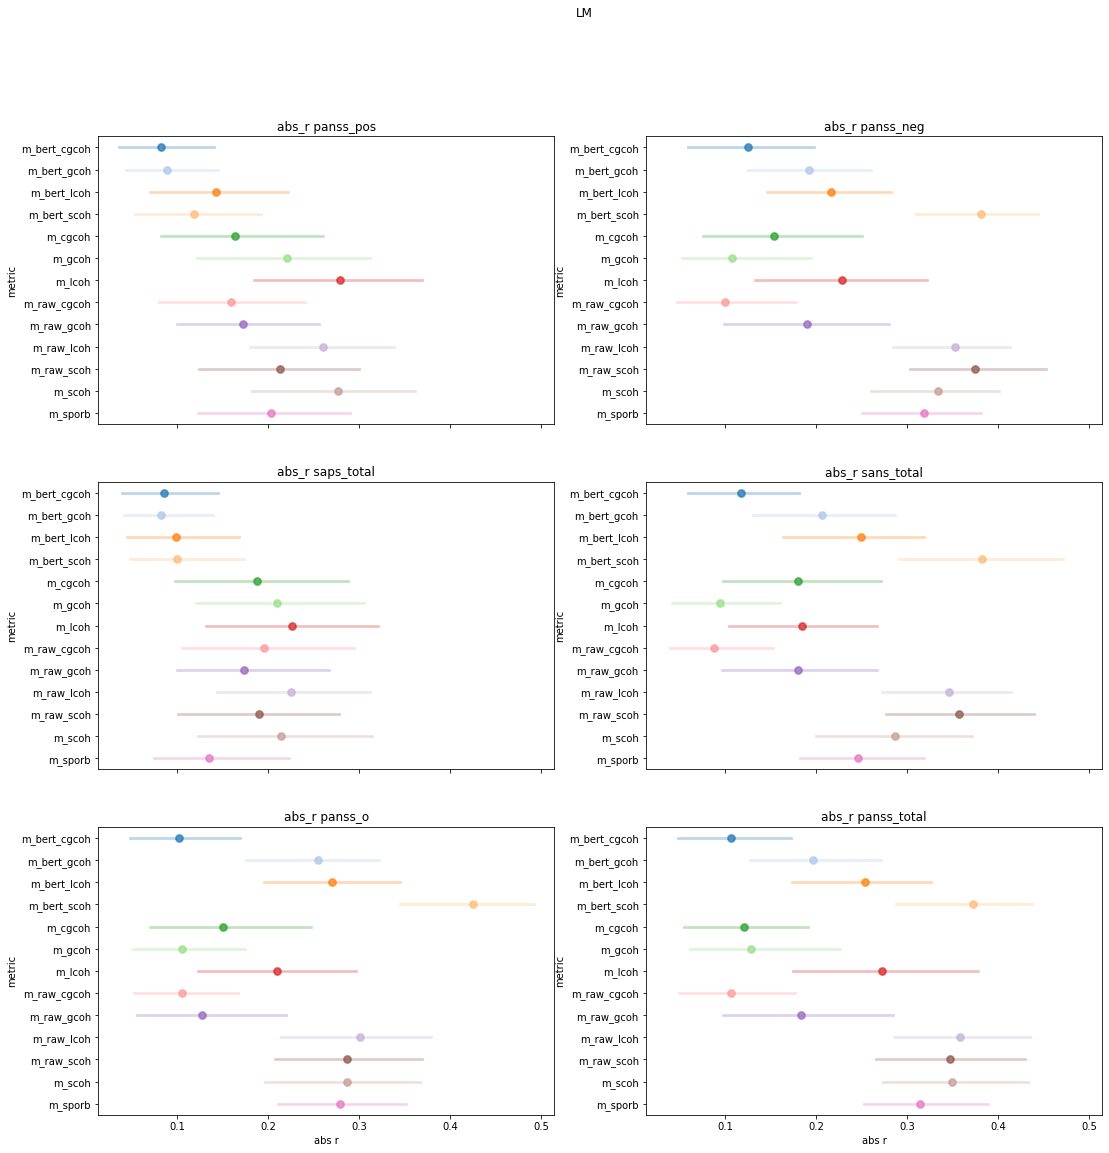

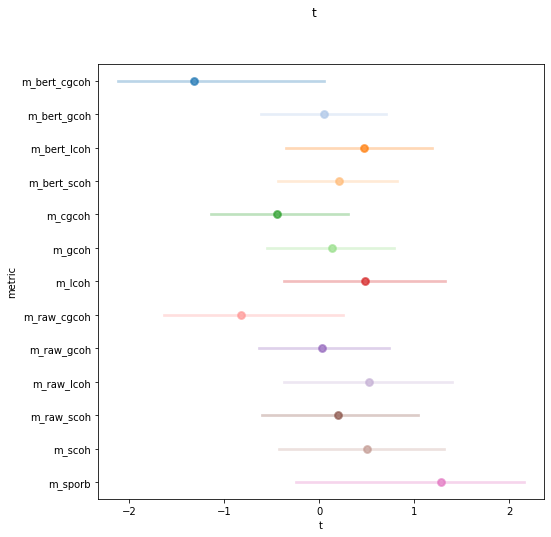

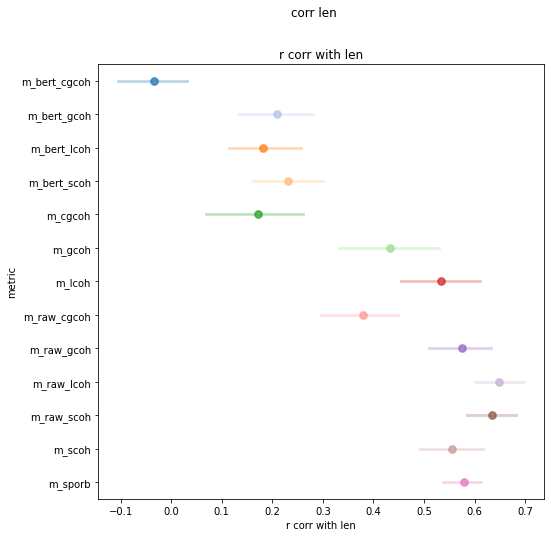

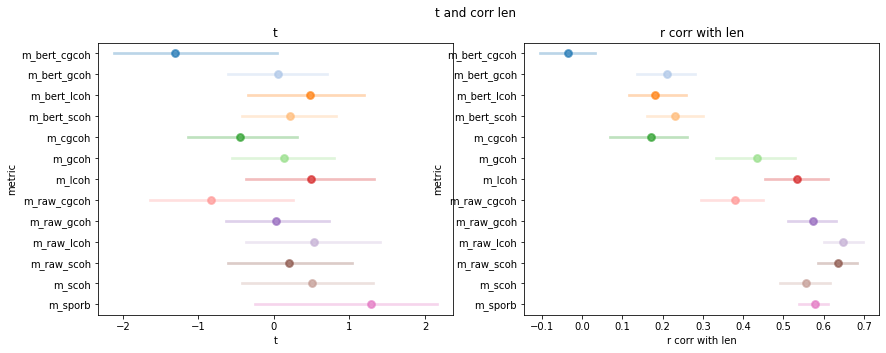

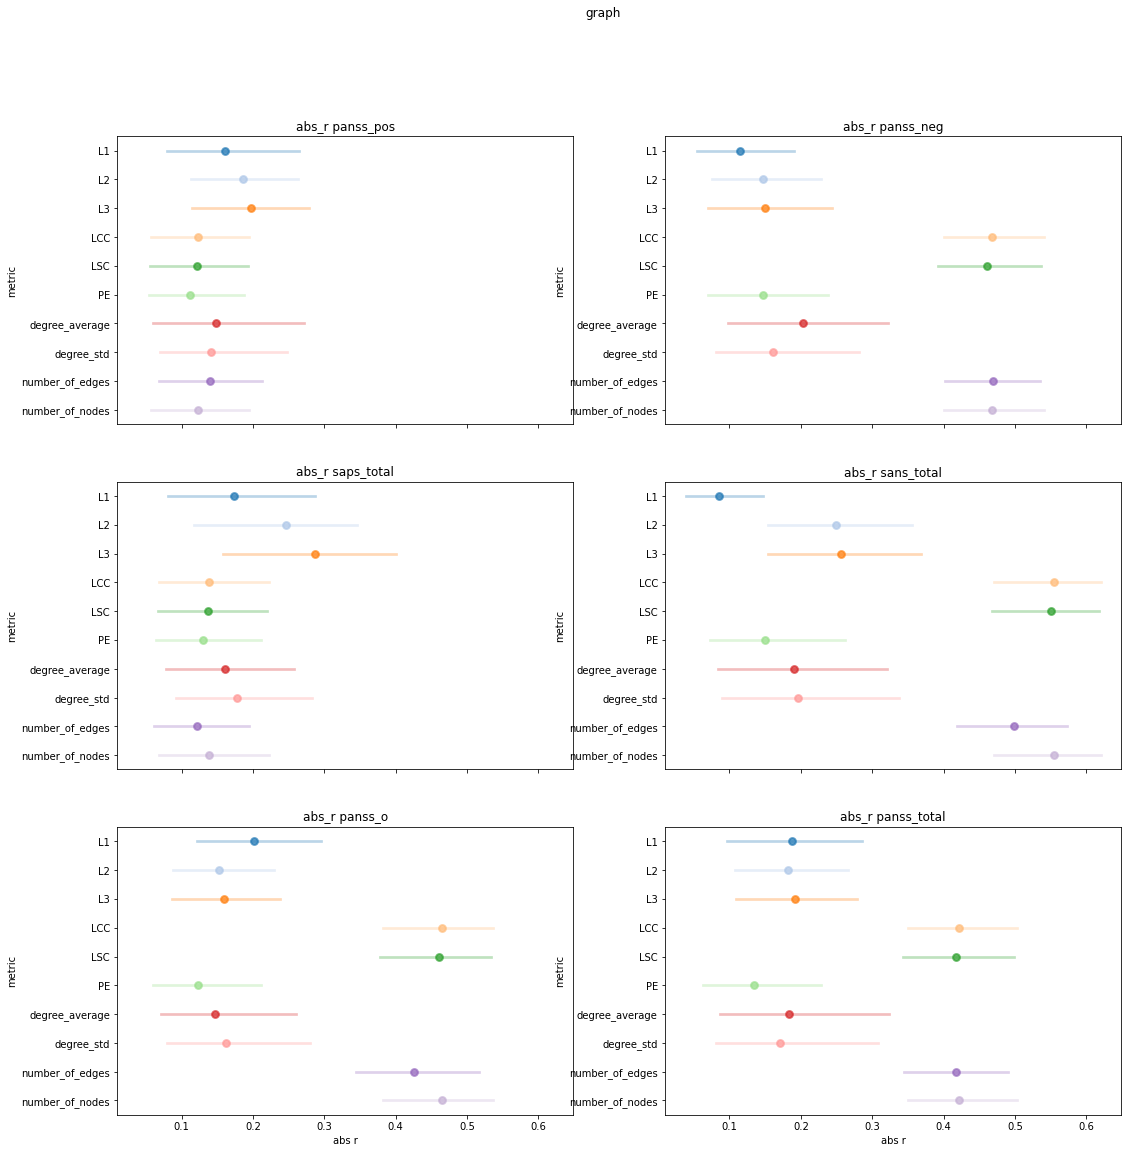

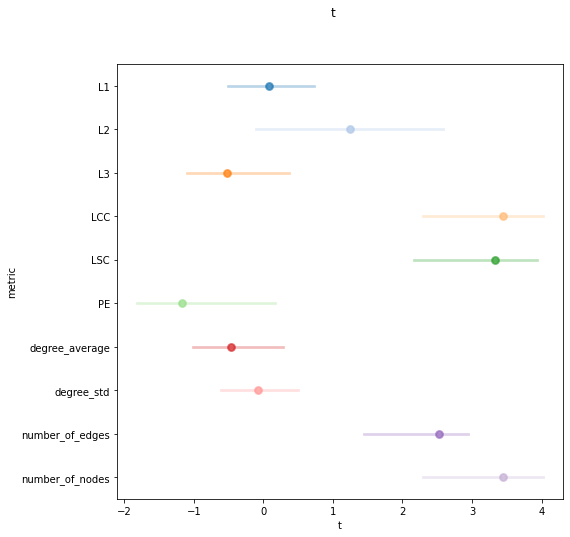

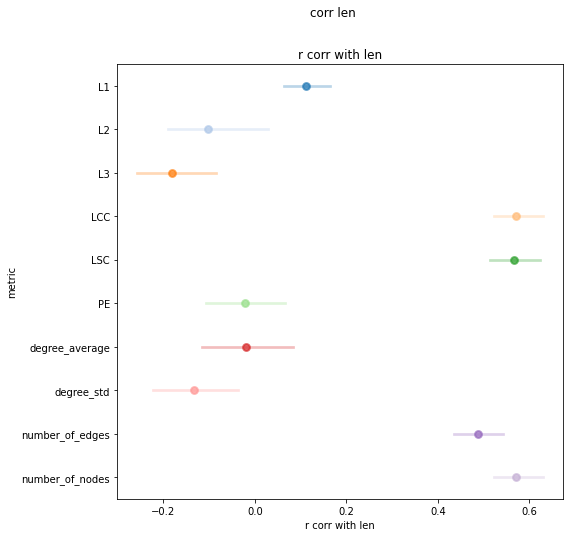

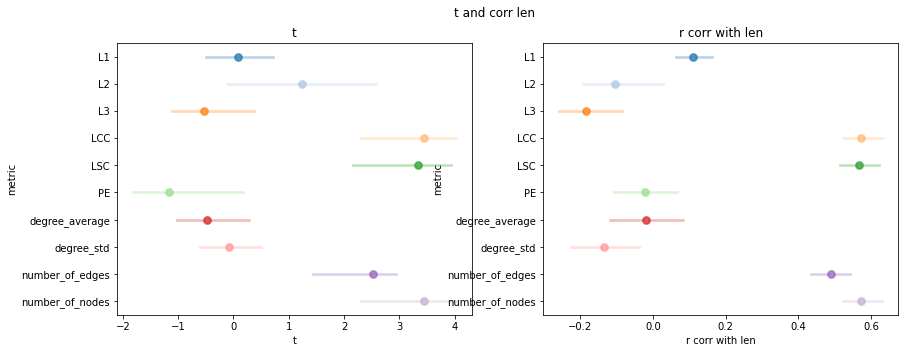

In [145]:
plot_all(reformed_d, plot_abs=True)
plot_all(reformed_d, 'lexical', plot_abs=True)
plot_all(reformed_d, 'LM', plot_abs=True)
plot_all(reformed_d, 'graph', plot_abs=True)

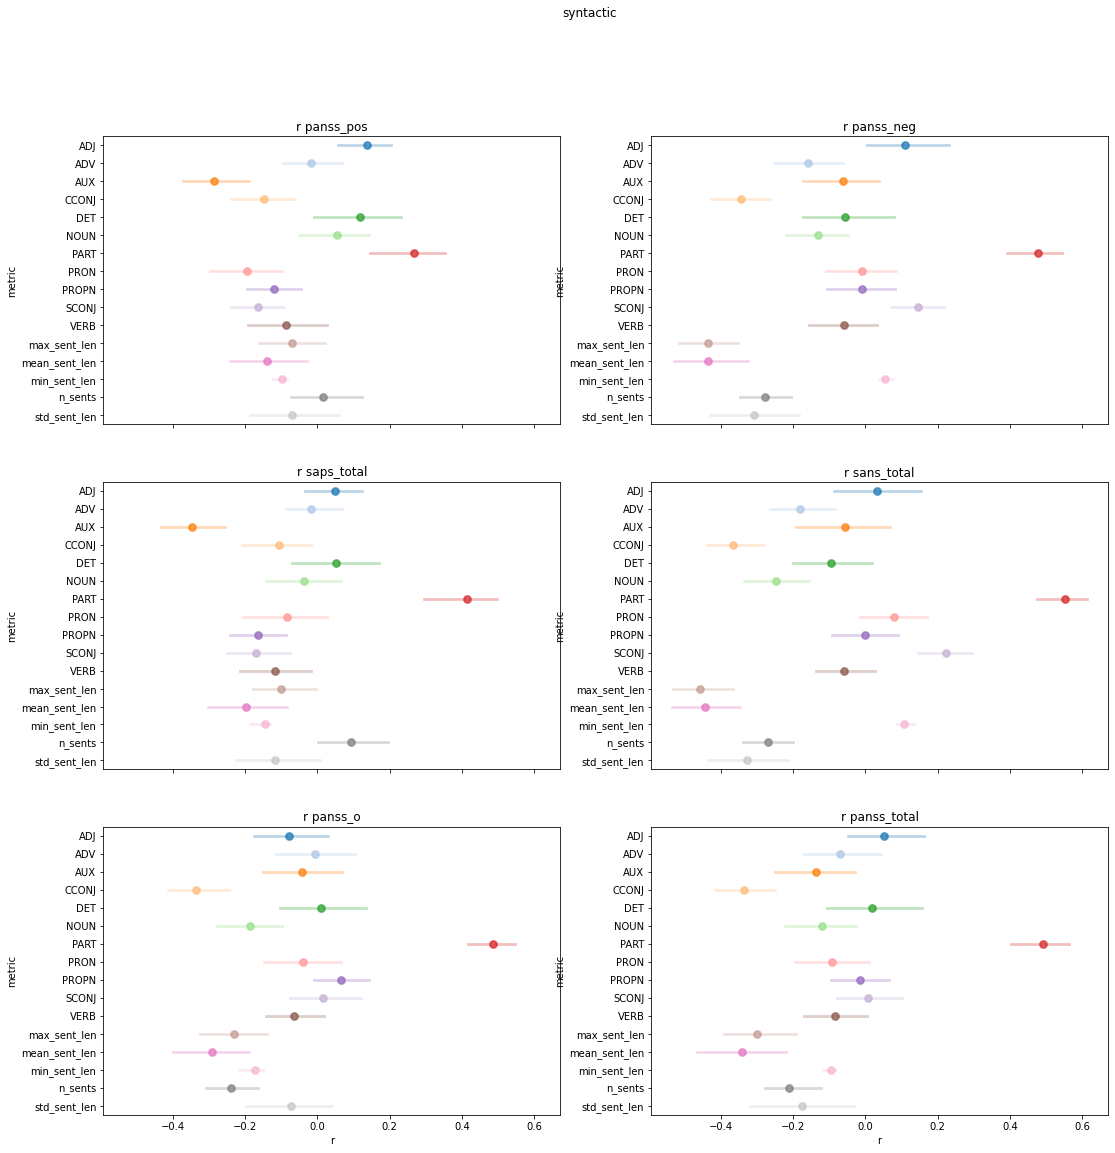

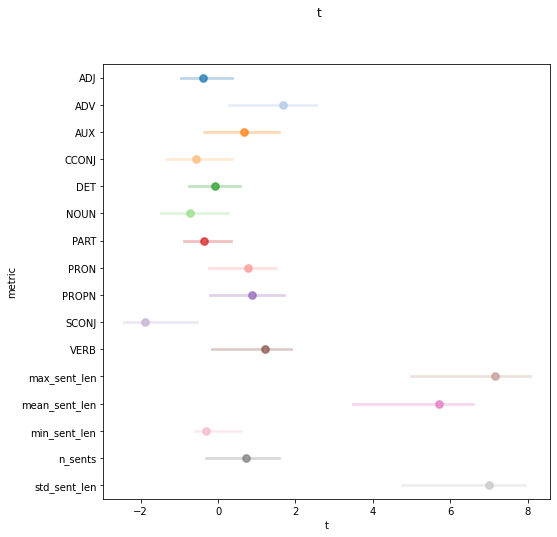

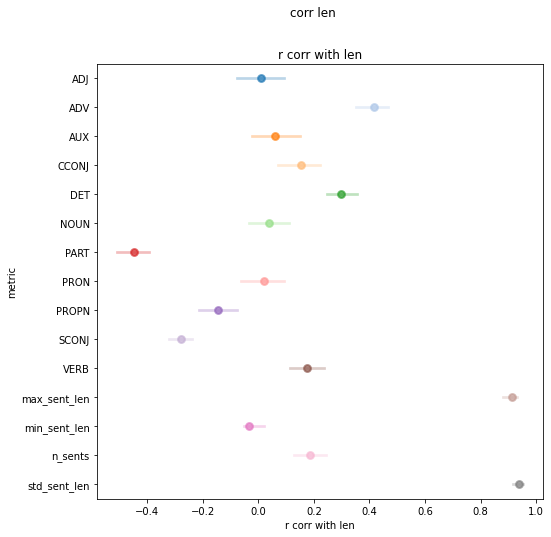

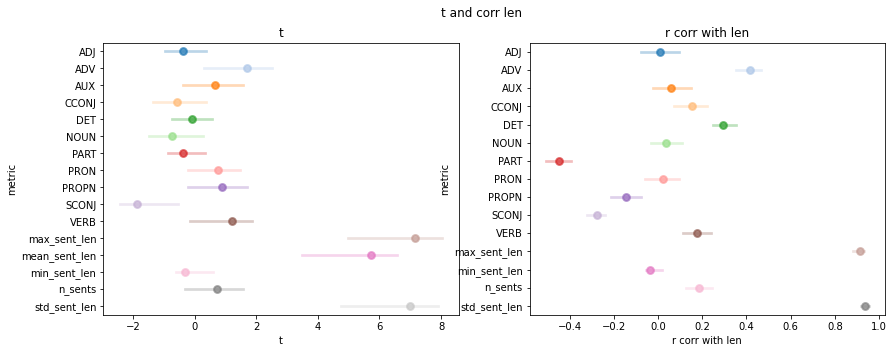

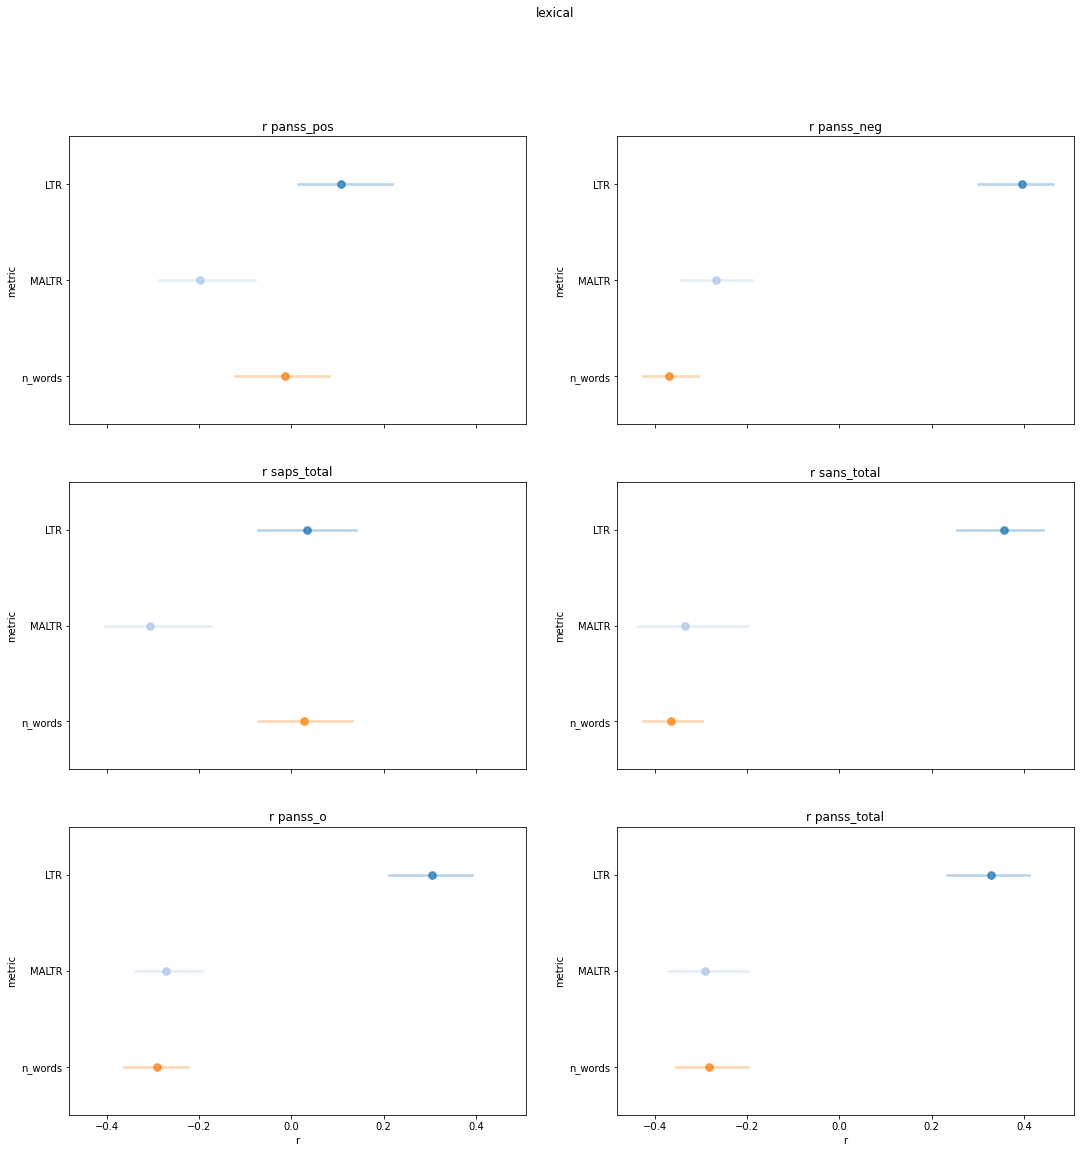

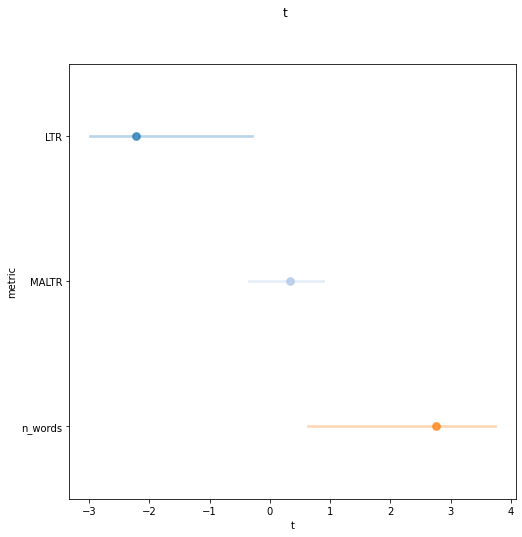

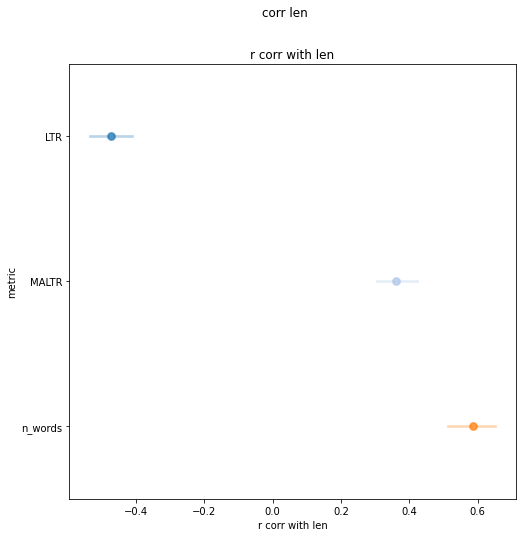

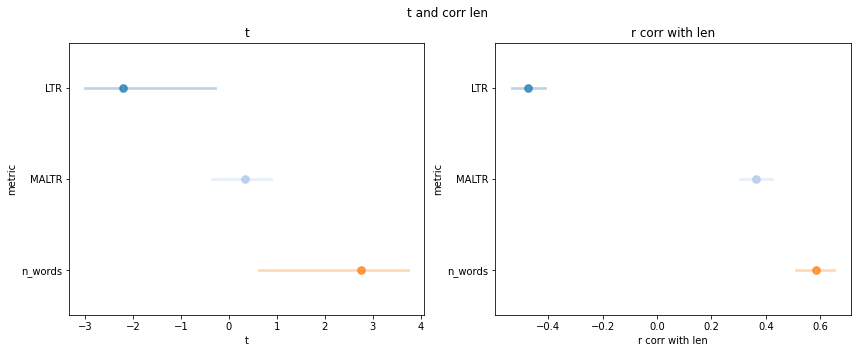

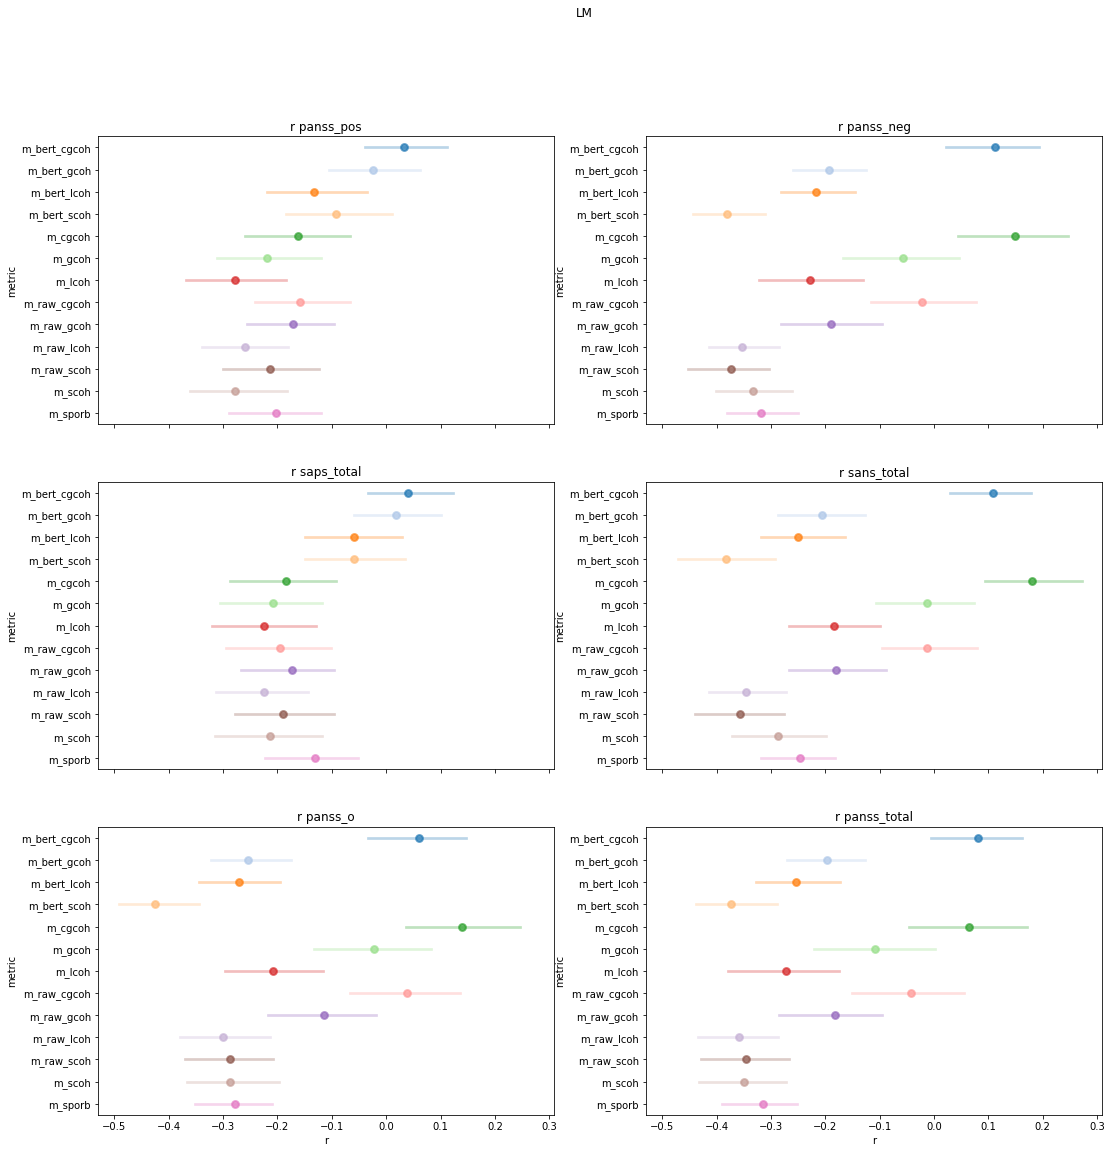

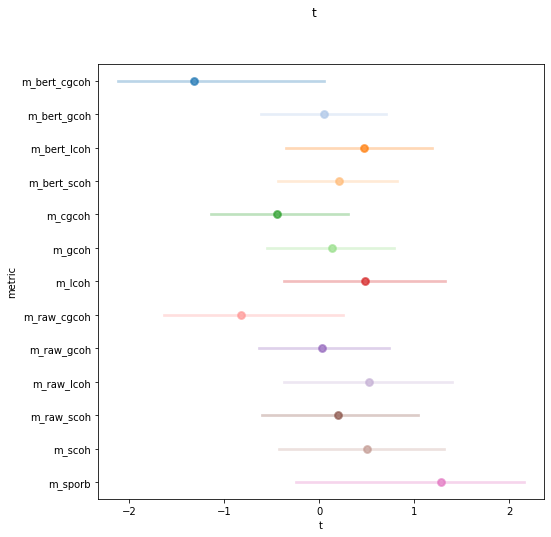

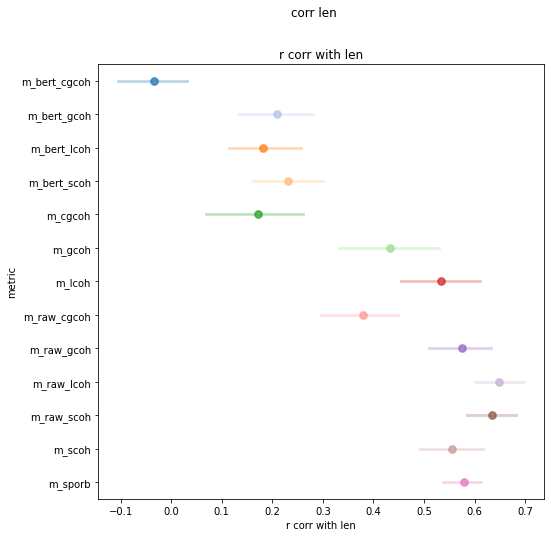

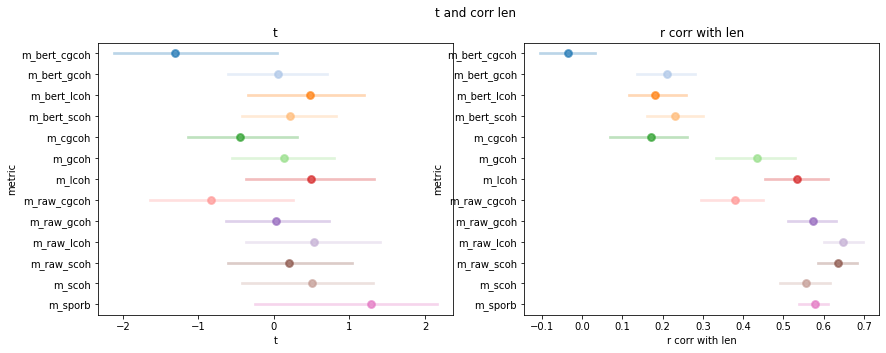

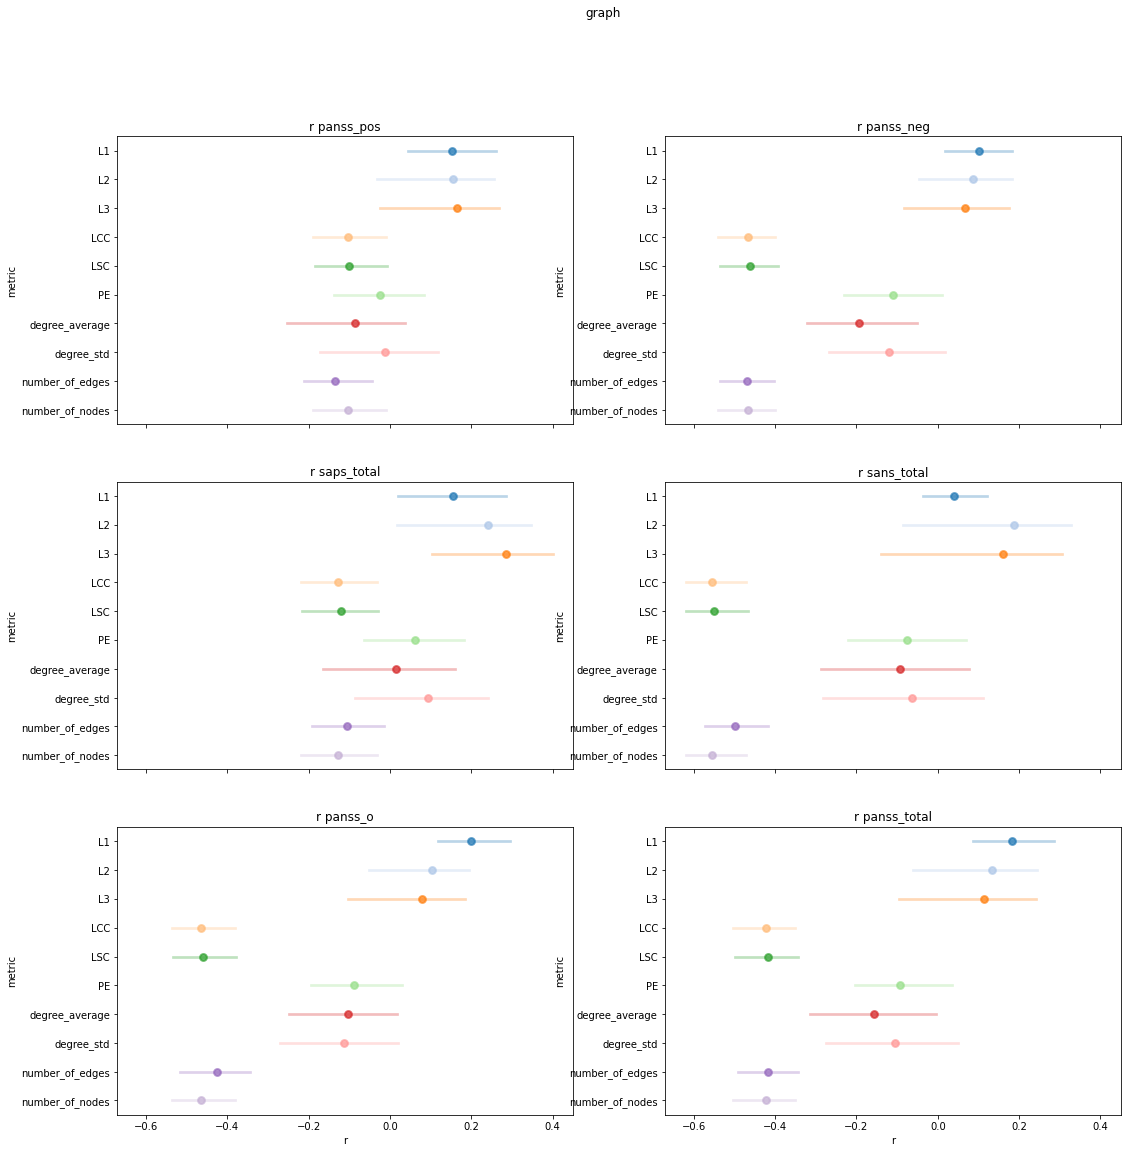

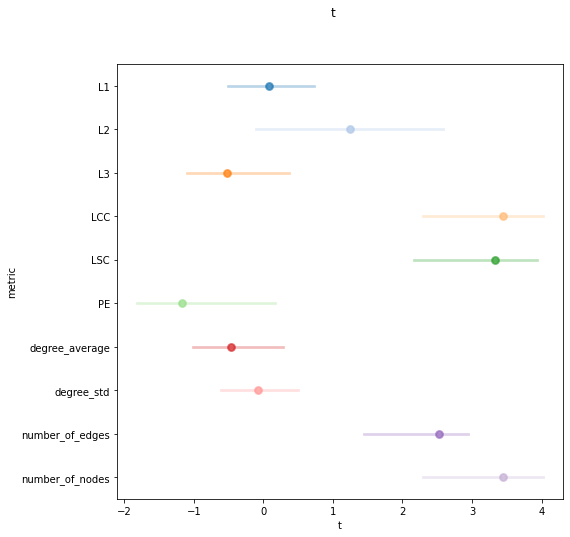

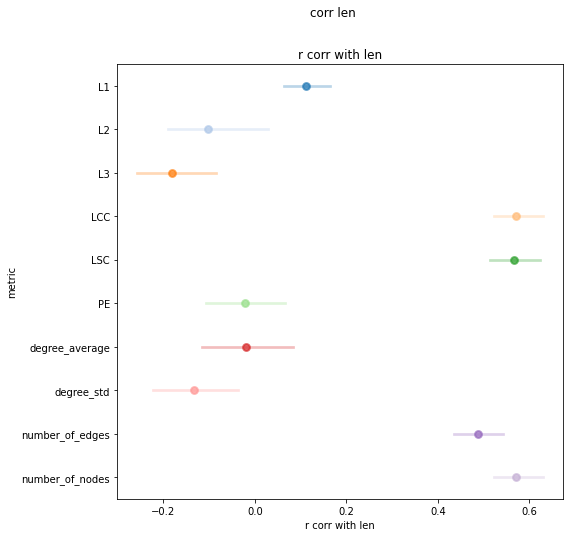

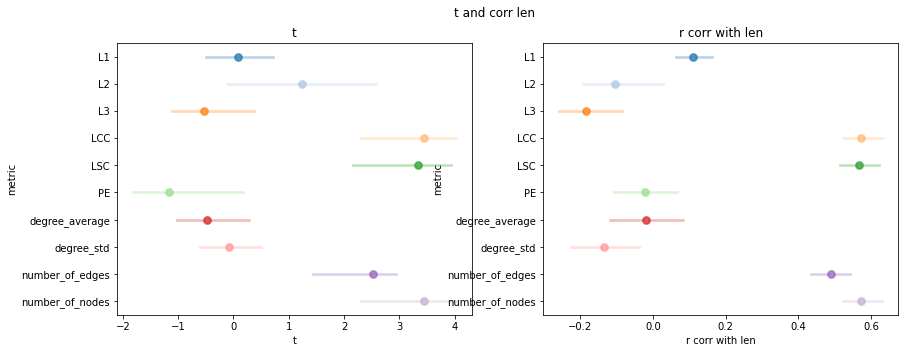

In [146]:
plot_all(reformed_d, plot_abs=False)
plot_all(reformed_d, 'lexical', plot_abs=False)
plot_all(reformed_d, 'LM', plot_abs=False)
plot_all(reformed_d, 'graph', plot_abs=False)

In [147]:
def map_model(m):
    if 'bert' in m or 'sprob' in m or 'sporb' in m:
        return 'bert'
    elif 'raw' in m:
        return 'w2v_raw'
    else:
        return 'w2v'

In [148]:
def prep_LM_pointplot_data(df, plot_abs=False):
#     df.drop(index='m_sporb', inplace=True)
    if plot_abs:
        df = df.applymap(abs)
    df['model'] = [map_model(m) for m in df.index]
    df['metric'] = [x.split('_')[-1] for x in df.index]
    return df

In [149]:
def prep_LM_pointplot_errobar_data(df, col, plot_abs=False):
    r = np.concatenate(df[col].to_numpy())
    if plot_abs:
        r = map(abs, r)
    idx = np.concatenate([[x]*len(df[col][x]) for x in df[col].index])
    d = pd.DataFrame(data=r, columns=[col])
    d['model'] = list(map(map_model, idx))
    d['metric'] = list(map(lambda x: x.split('_')[-1], idx))
    return d

In [150]:
def prep_LM_pointplot(df, col, plot_abs=False, use_errorbar=True):
    if not use_errorbar:
        return prep_LM_pointplot_data(df, plot_abs=plot_abs)
    else:
        return prep_LM_pointplot_errobar_data(df, col, plot_abs=plot_abs)

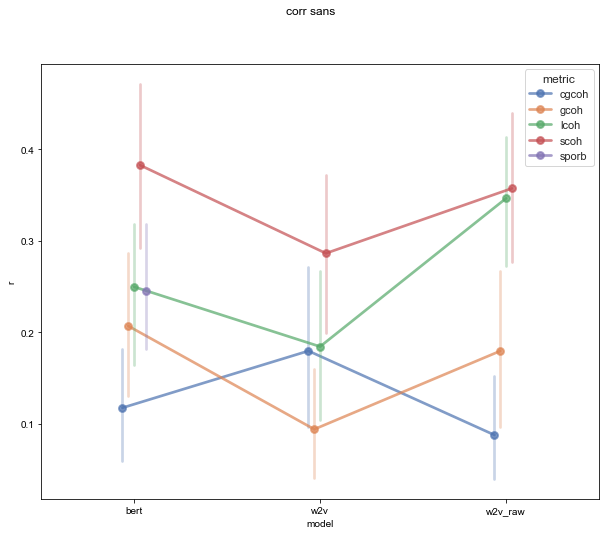

In [151]:
order=['bert', 'w2v', 'w2v_raw']
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle('corr sans')
d = prep_LM_pointplot(reformed_d.loc['LM', 'sans_total'], 'r', plot_abs=True)
pointplot(d, x='model', y='r', hue='metric', ax=ax, use_errorbar=True, order=order)

In [152]:
def plot_LM_scales(df, title, measure='r', plot_abs=False, figsize=(18, 18), order=order):
    fig, axes = plt.subplots(3, 2, figsize=figsize, sharey=True)
    fig.suptitle(title)
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_pos'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[0, 0], order=order, use_errorbar=True)
    axes[0, 0].set_title(f'{measure} panss_pos')
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_neg'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[0, 1], order=order, use_errorbar=True)
    axes[0, 1].set_title(f'{measure} panss_neg')
    
    d = prep_LM_pointplot(df.loc['LM', 'saps_total'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[1, 0], order=order, use_errorbar=True)
    axes[1, 0].set_title(f'{measure} saps_total')
    
    
    d = prep_LM_pointplot(df.loc['LM', 'sans_total'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[1, 1], order=order, use_errorbar=True)
    axes[1, 1].set_title(f'{measure} sans_total')
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_o'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[2, 0], order=order, use_errorbar=True)
    axes[2, 0].set_title(f'{measure} panss_o')
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_total'], measure, plot_abs=plot_abs)
    pointplot(d, x='model', y=measure, hue='metric', ax=axes[2, 1], order=order, use_errorbar=True)
    axes[2, 1].set_title(f'{measure} panss_total')
    

    if plot_abs:
        for ax in axes.reshape(-1): 
            ax.set_xlabel('abs ' + measure);

In [153]:
# plot_LM_scales(reformed_d, 'corr', plot_abs=True)

In [217]:
def plot_all_LM(df, path='/Users/galina.ryazanskaya/Downloads/thesis?/figures/de', 
             dpi=150, plot_abs=False, figsize=(8, 8)):
    
    ab = 'abs_' if plot_abs else ''
    plot_LM_scales(df, 'corr', plot_abs=plot_abs)
    plt.savefig(f'{path}/LM/model/{ab}scale_r.png', dpi=dpi)
    
    d_lm_t = prep_LM_pointplot(df.loc['LM', 'panss_o'], 't')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('t')
    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=ax, order=order, use_errorbar=True)
    plt.savefig(f'{path}/LM/model/t.png', dpi=dpi)
    
    d_lm_c = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'r_corr_w_control')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('corr len')
    pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=ax, order=order, use_errorbar=True)
    plt.savefig(f'{path}/LM/model/corr_len.png', dpi=dpi)
    

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('t and corr len')

    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=axes[0], order=order, use_errorbar=True)
    axes[0].set_title('t')

    pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=axes[1], order=order, use_errorbar=True)
    axes[1].set_title('r corr with len')
    axes[1].set_xlabel('r corr with len');
    plt.savefig(f'{path}/LM/model/t_test_corr_len.png', dpi=dpi)

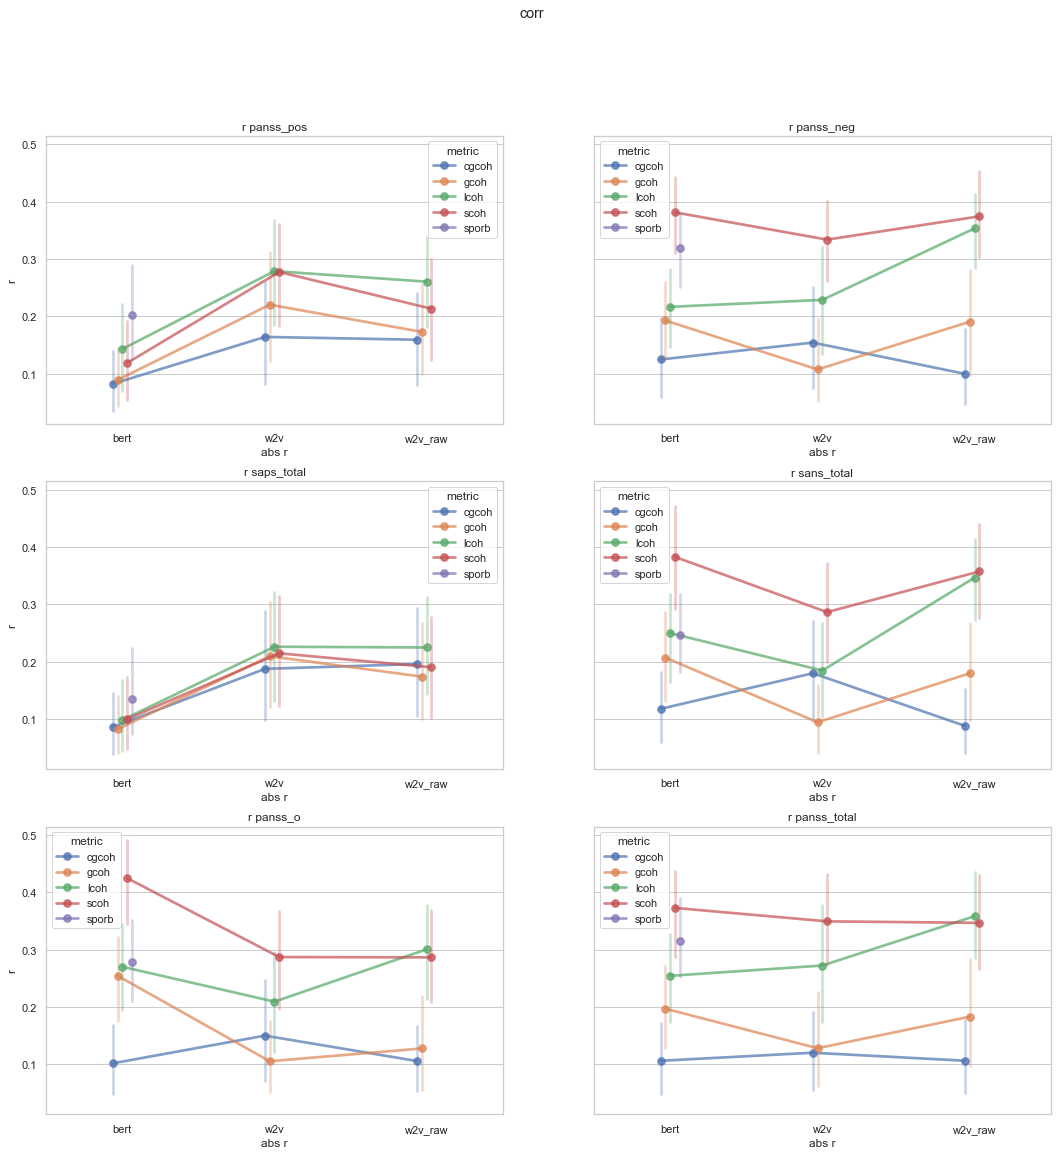

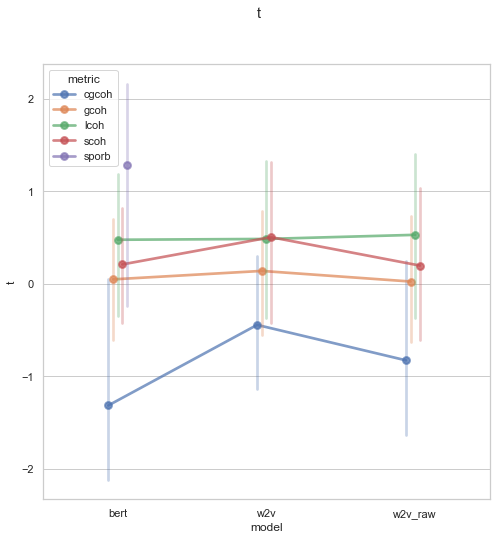

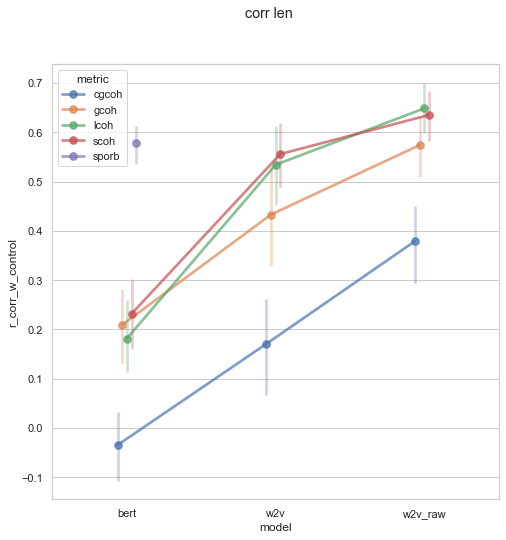

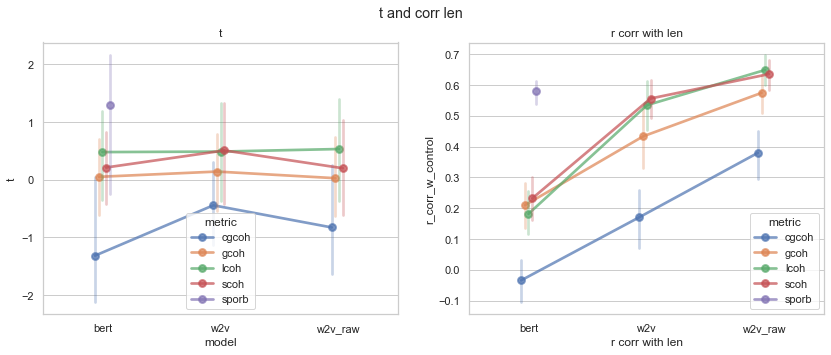

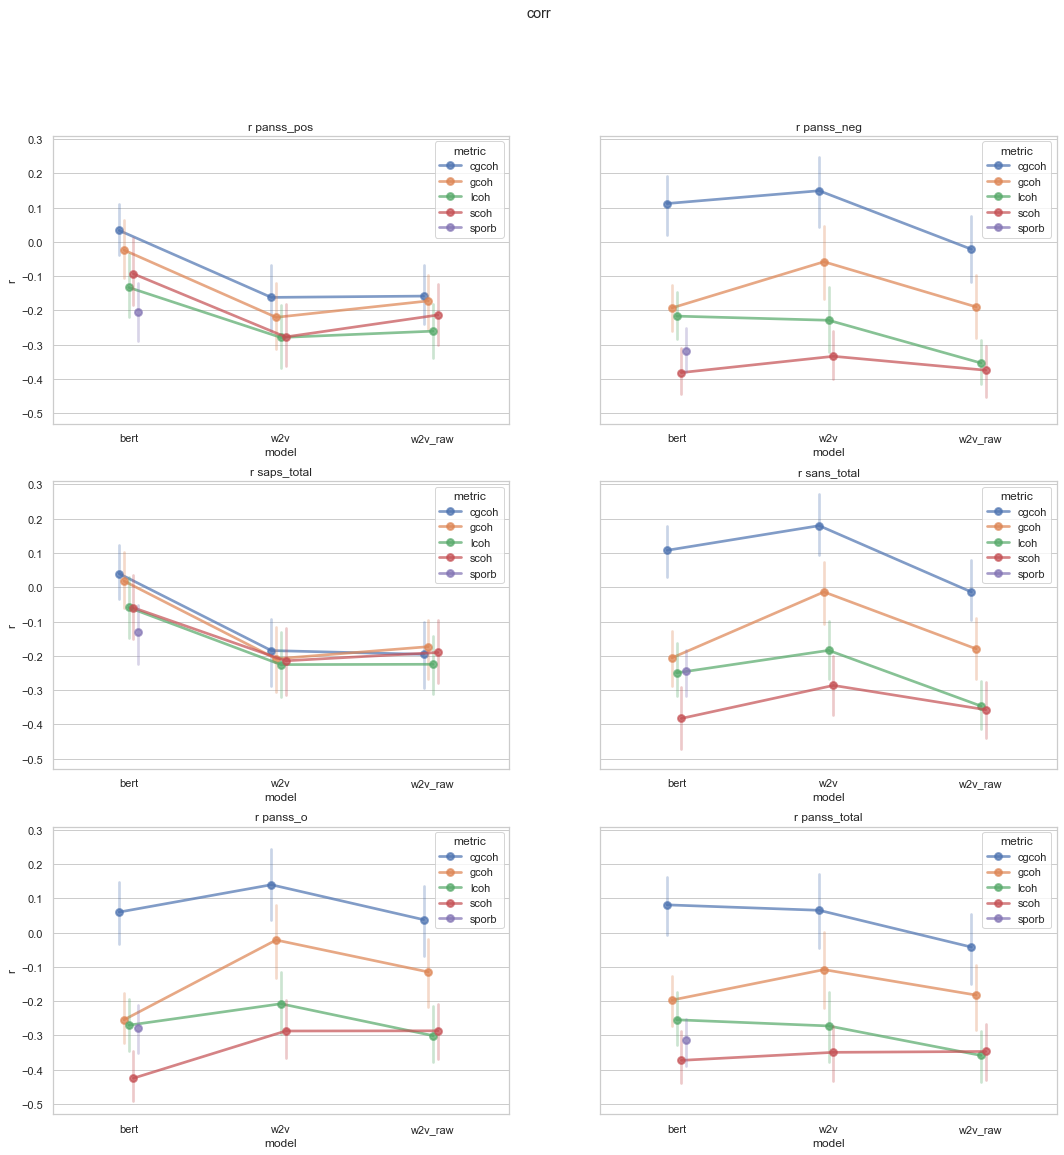

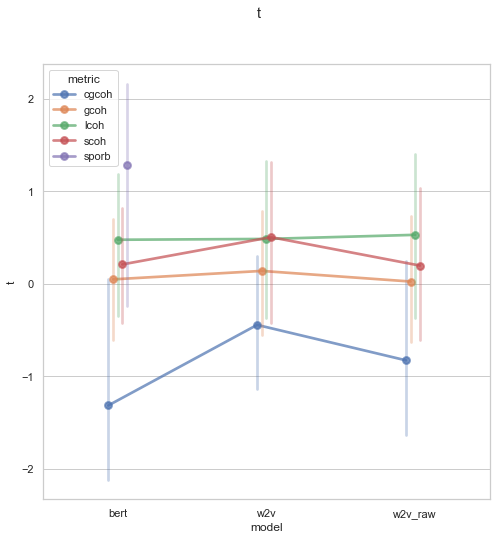

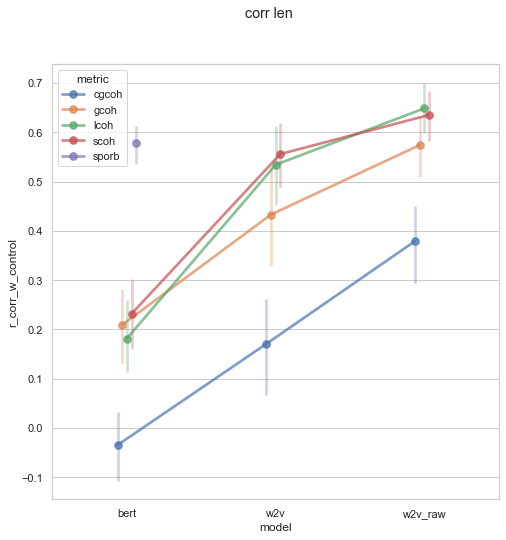

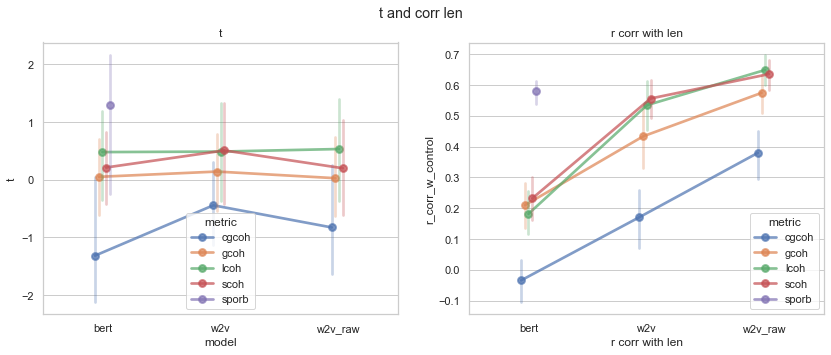

In [155]:
plot_all_LM(reformed_d, plot_abs=True)
plot_all_LM(reformed_d, plot_abs=False)

In [156]:
sample_df = pd.DataFrame()
for scale in scale_cols:
    scale_metric_sd = {}
    scale_metric_md = {}
    scale_metric_mn = {}
    scale_metric_cov = {}
    scale_metric_diff = {}
    scale_metric_q25 = {}
    scale_metric_q75 = {}
    for col in cols_av:
        if col != ('syntactic', 'mean_sent_len'):
            sample = reform[(scale, 'sample_corr')][col]
            scale_metric_sd[col] = np.std(sample)
            scale_metric_md[col] = np.median(sample)
            scale_metric_mn[col] = np.mean(sample)
            scale_metric_q25[col] = np.quantile(sample, 0.25)
            scale_metric_q75[col] = np.quantile(sample, 0.75)
            scale_metric_cov[col] = np.std(sample) / np.mean(sample)
            scale_metric_diff[col] = np.mean(sample) / np.mean(reform[(scale, 'sample_raw')][col])
            
    sample_df[(scale, 'md')] = pd.Series(scale_metric_md)
    sample_df[(scale, 'mn')] = pd.Series(scale_metric_mn)
    sample_df[(scale, 'sd')] = pd.Series(scale_metric_sd)
    sample_df[(scale, 'cov')] = pd.Series(scale_metric_cov)
    sample_df[(scale, 'dif')] = pd.Series(scale_metric_diff)
    sample_df[(scale, 'q25')] = pd.Series(scale_metric_q25)
    sample_df[(scale, 'q75')] = pd.Series(scale_metric_q75)

In [157]:
# sample_df

In [158]:
sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))

In [159]:
ex_df = sample_df.loc['LM', 'sans_total'].drop(index='m_sporb')
ex_df['model'] = [map_model(m) for m in ex_df.index]
ex_df['metric'] = [x.split('_')[-1] for x in ex_df.index]
# ex_df

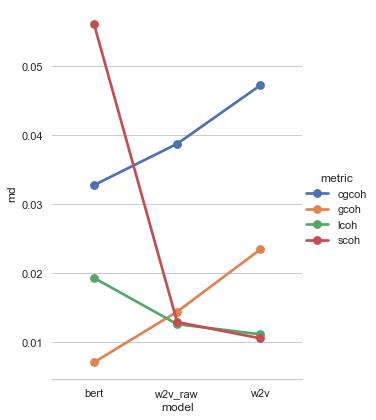

In [160]:
sns.set_theme(style="whitegrid")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=ex_df, x="model", y="md", hue="metric", order=['bert', 'w2v_raw', 'w2v'],
    capsize=.2,  # errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [161]:
sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))
styler = pd.io.formats.style.Styler(sample_df, precision = 4)
styler.background_gradient(axis=0, cmap='Reds')

In [162]:
# sns.histplot(dict_scales_sapmles['sample_corr']['sans_total'][('syntactic', 'AUX')], bins=30);

In [163]:
# sns.histplot(dict_scales_sapmles['sample_corr']['sans_total'][('LM', 'm_cgcoh')], bins=30);

In [164]:
# sns.histplot(dict_scales_sapmles['sample_corr']['sans_total'][('LM', 'm_bert_cgcoh')], bins=30);

### original

In [205]:
# plt.scatter(combined_data_averaged[('syntactic', 'mean_sent_len')], combined_data_averaged[('syntactic', 'AUX')]);

In [206]:
# ex_df = combined_data_averaged[combined_data_averaged[('syntactic', 'mean_sent_len')] > 5]
# draw_corrected_scatter(ex_df, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'),
#                       column_names=['sent len', 'punct'], target_name='sans')

In [167]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.004861777549361124

In [168]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.0484042806725139

In [201]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'),
#                       column_names=['sent len', 'm_cgcoh'], target_name='sans')

In [196]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'NOUN'),
#                       column_names=['sent len', 'num'], target_name='sans')

In [197]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('graph', 'number_of_edges'),
#                       column_names=['sent len', 'NE'], target_name='sans')

In [198]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('graph', 'number_of_nodes'),
#                       column_names=['sent len', 'NN'], target_name='sans')

In [199]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('lexical', 'MALTR'),
#                       column_names=['sent len', 'maltr'], target_name='sans')

In [200]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'),
#                       column_names=['sent len', 'm_cgcoh'], target_name='sans')

In [175]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('sans_total', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [177]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'saps_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('saps_total', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [179]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'panss_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('panss', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [181]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_logit(combined_data_averaged, 'group', ('syntactic', 'mean_sent_len'), col)
combined_corr.insert(1, ('t_test', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [182]:
t_p_n_corr_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'r_corrected_for_mean_len')].rank(ascending=False) for scale in ['sans_total', 'saps_total']], axis=1).mean(axis=1)
combined_corr.insert(1, ('mean', 'tpn_rank_corr'), t_p_n_corr_rank) 
combined_corr.insert(2, ('mean', 'tpn_rank_corr_abs'), t_p_n_corr_rank.rank()) 

In [183]:
combined_corr.sort_values(('mean', 'tpn_rank_corr'), ascending=True).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [184]:
def get_ranking_difference(df, col_initial, col_final):
    return df[col_final].rank() - df[col_initial].rank()

In [185]:
rank_diff = pd.DataFrame()
rank_diff[('panss', 'rank_change')] = get_ranking_difference(combined_corr, ('panss', 'abs_r'), ('panss', 'r_corrected_for_mean_len'))
rank_diff[('panss', 'corrected_rank')] = combined_corr[('panss', 'r_corrected_for_mean_len')].rank()
rank_diff[('panss', 'corrected_r')] = combined_corr[('panss', 'r_corrected_for_mean_len')]


rank_diff[('sans', 'rank_change')] = get_ranking_difference(combined_corr, ('sans_total', 'abs_r'), ('sans_total', 'r_corrected_for_mean_len'))
rank_diff[('sans', 'corrected_rank')] = combined_corr[('sans_total', 'r_corrected_for_mean_len')].rank()
rank_diff[('sans', 'corrected_r')] = combined_corr[('sans_total', 'r_corrected_for_mean_len')]

rank_diff[('saps', 'rank_change')] = get_ranking_difference(combined_corr, ('saps_total', 'abs_r'), ('saps_total', 'r_corrected_for_mean_len'))
rank_diff[('saps', 'corrected_rank')] = combined_corr[('saps_total', 'r_corrected_for_mean_len')].rank()
rank_diff[('saps', 'corrected_r')] = combined_corr[('saps_total', 'r_corrected_for_mean_len')]

rank_diff[('t_test', 'rank_change')] = get_ranking_difference(combined_corr, ('t_test', 'abs_t'), ('t_test', 'r_corrected_for_mean_len'))
rank_diff[('t_test', 'corrected_rank')] = combined_corr[('t_test', 'r_corrected_for_mean_len')].rank()
rank_diff[('t_test', 'corrected_r')] = combined_corr[('t_test', 'r_corrected_for_mean_len')]
rank_diff[('t_test', 'val')] = combined_corr[('t_test', 'abs_t')]

rank_diff.columns = pd.MultiIndex.from_tuples(rank_diff.columns, names=('scale', 'res'))
rank_diff = rank_diff.apply(pd.to_numeric)

In [186]:
rank_diff.style.background_gradient(axis=0, cmap='Reds')

In [187]:
n = [label[1] for label in rank_diff.index]
c_map = {'LM': 0, 'graph': 1, 'lexical': 2, 'syntactic': 3}
c = [c_map[label[0]] for label in rank_diff.index]

In [188]:
def plot_res_corr(x, y, n, x_name, y_name, title, c=None):
    r = stats.pearsonr(x, y).statistic
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    ypred = model.predict(X)
    plt.plot(x, ypred, color='red', label=f'coef: {model.params[1]:.2f} \ncorr: {r:.2f}')

    plt.gca().add_artist(plt.legend(loc=9))

    scatter_annotate(x, y, n, x_name, y_name, title, c=c)

In [208]:
plt.rcParams["figure.figsize"] = (15,8)

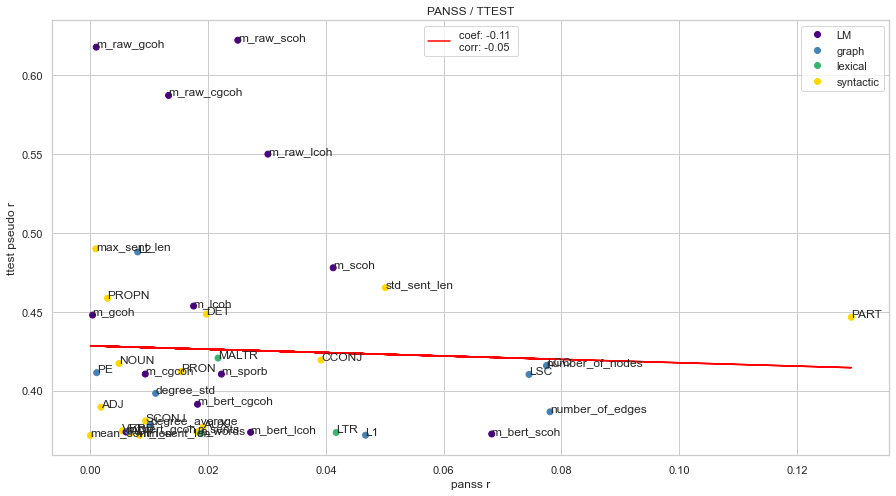

In [209]:
x = rank_diff[('panss', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'panss r', 'ttest pseudo r', 'PANSS / TTEST', c)

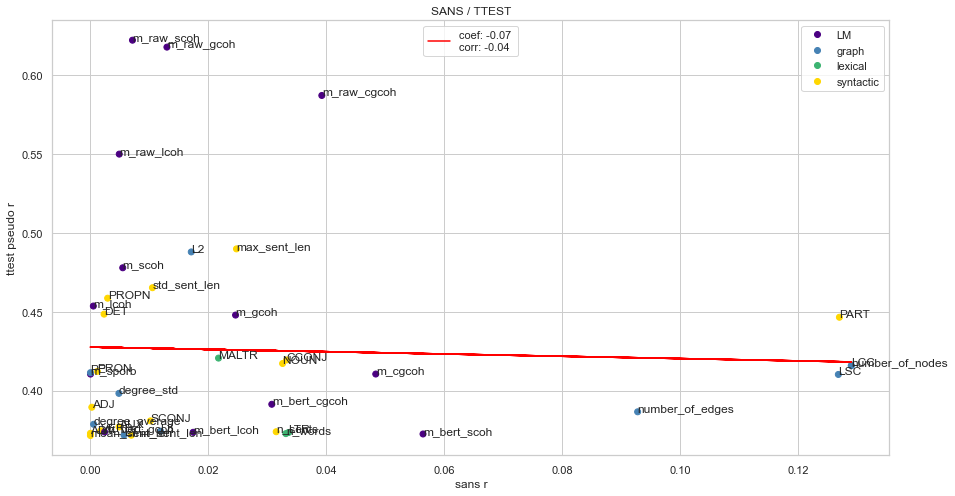

In [210]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'ttest pseudo r', 'SANS / TTEST', c)

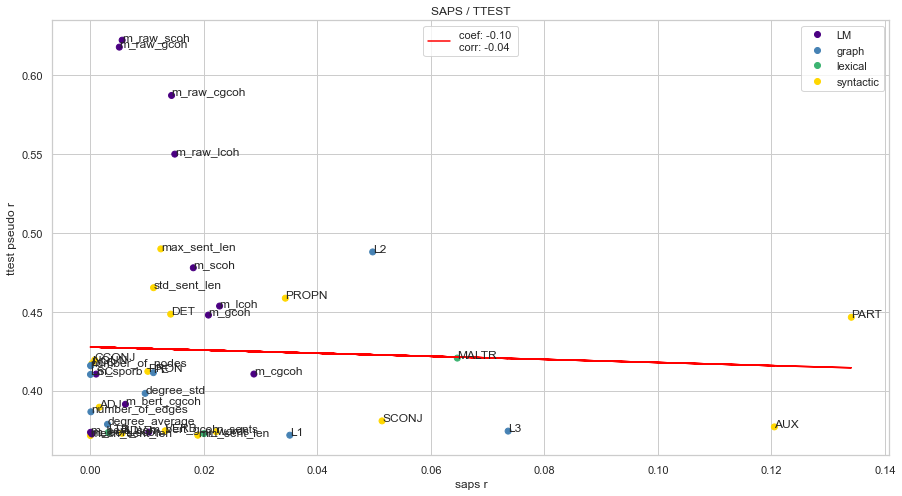

In [211]:
x = rank_diff[('saps', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'saps r', 'ttest pseudo r', 'SAPS / TTEST', c)

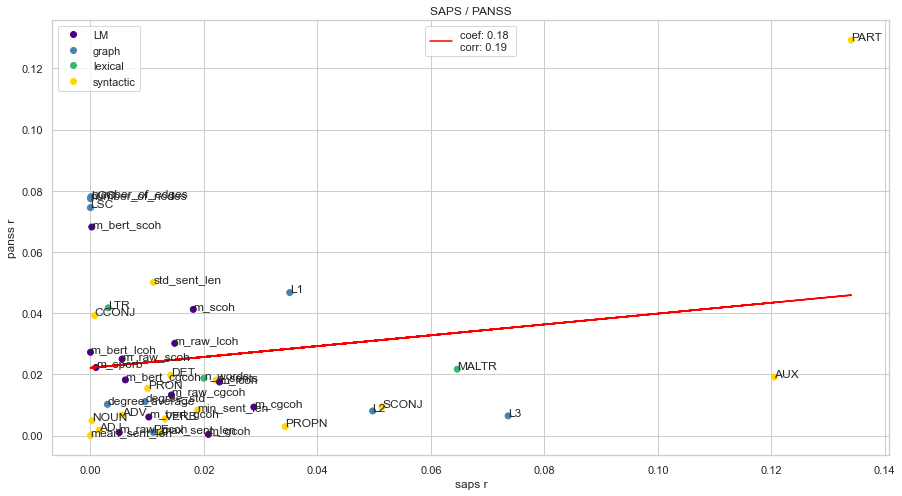

In [212]:
x = rank_diff[('saps', 'corrected_r')]
y = rank_diff[('panss', 'corrected_r')]

plot_res_corr(x, y, n, 'saps r', 'panss r', 'SAPS / PANSS', c)

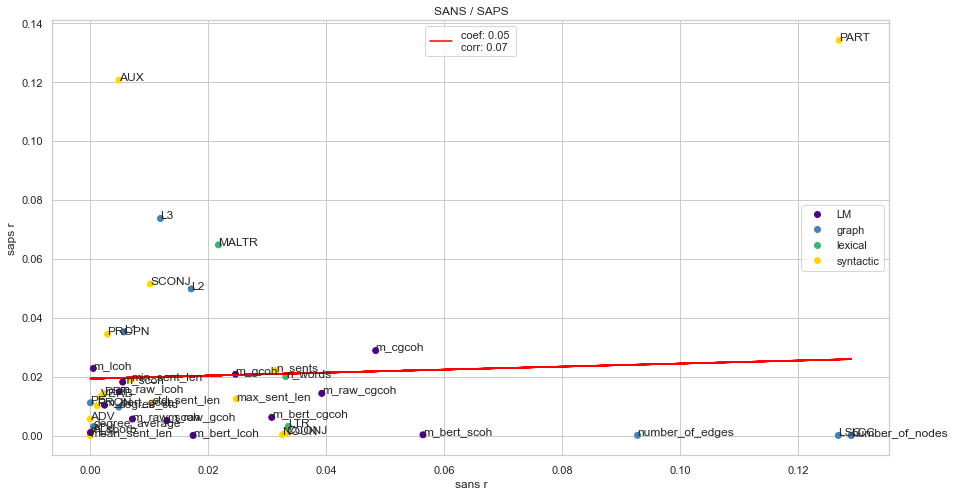

In [213]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('saps', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'saps r', 'SANS / SAPS', c)

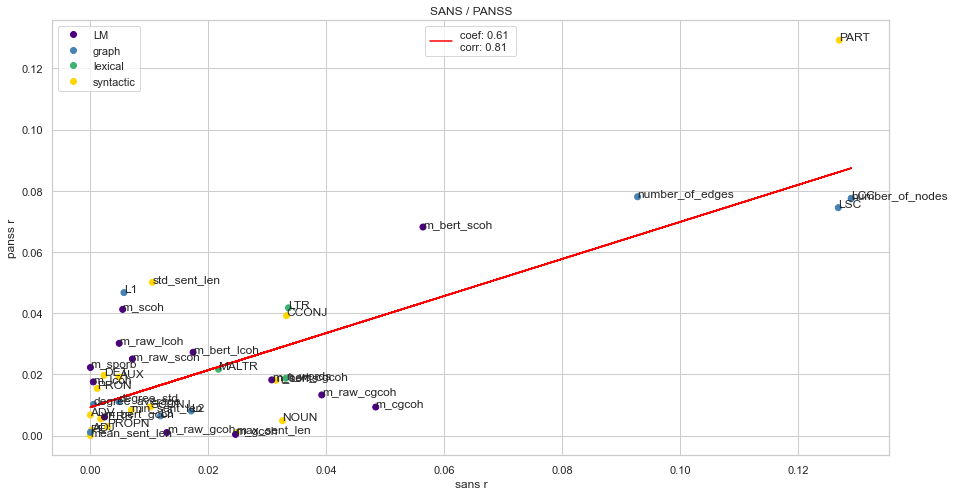

In [214]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('panss', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'panss r', 'SANS / PANSS', c)

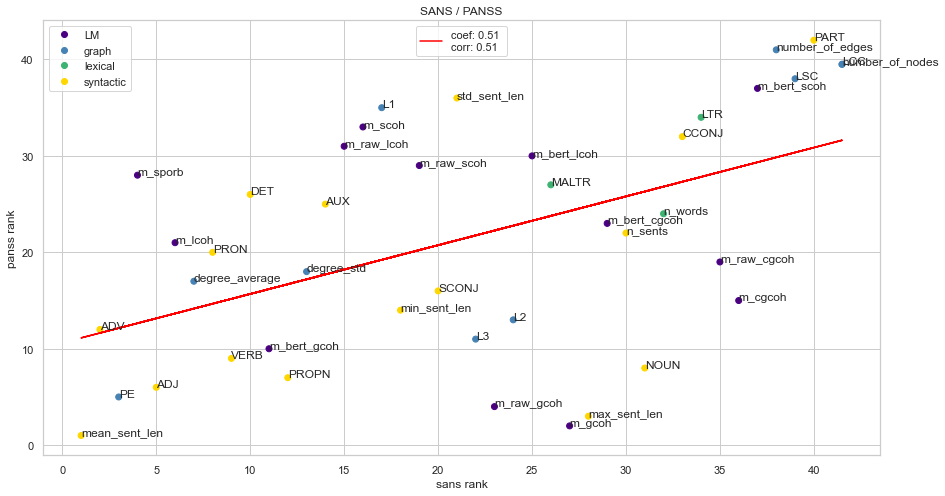

In [215]:
x = rank_diff[('sans', 'corrected_rank')]
y = rank_diff[('panss', 'corrected_rank')]

plot_res_corr(x, y, n, 'sans rank', 'panss rank', 'SANS / PANSS', c)